## Final Project Submission

Please fill out:
* Student name: Max Steele
* Student pace: full time
* Scheduled project review date/time: Friday, August 7 at 6:00 PM
* Instructor name: James Irving
* Blog post URL: https://zero731.github.io/using_violin_and_stripplots_in_combination


# Introduction

   In an alternate universe, Microsoft has decided to start a new movie studio and begin making original movies. However, they are completely new to the movie industry as a company, and have hired me to analyze current industry trends and provide actionable insights into what types of movies they should make. Through my analysis, I will seek to answer the following questions:
1. Which genres are top grossing worldwide and have the highest return on investment?
* Of the top genres, how does movie budget affect metrics of financial success?
* Of the top genres, how does genre influence movie rating?

Because the industry creates such a wide diversity of movies, it seems pertinent to help the company focus on a smaller scope of movie types that can be expected to perform well based on current industry trends. Question 1 aims to accomplish this by finding out which genres have been the highest grossing and produced the best return on investment in the last decade. 

The second question will then help the company determine how much money it should invest in making each movie by examining how movie budget influences worldwide gross earnings and return on investment within each genre. Presumably, being such a large company, Microsoft will be able to budget at least the industry-standard towards each movie. Each movie's budget should be enough to make a quality movie, and it's possible this varies by genre. We also want to avoid overspending on movies that can be made well on a lower budget. 

Question 3 considers a different aspect of what makes a good movie. While the overarching goal is to make money by making movies, Microsoft should also care about movie ratings. We should not assume that movies with higher ratings make more money; however, ratings are arguably still important. A nascent movie studio needs to quickly build a good reputation for itself. Even if the first few movies perform well at the box office and produce sizeable returns on investment, the movie studio could still go under in the longterm if it becomes known for producing mediocre movies. The studio will need to attract some of the best talent in the industry (writers, producers, and actors) to remain viable, especially since so many movie studios are already well established. It is not unreasonable to assume that many big names would not want to become artistically associated with a studio that produces poorly rated movies.

# Data Preparation

The data used to answer the above questions, explore recent trends in the movie industry, and provide recommendations for Microsoft's new movie studio were obtained from IMDb. Two files were downloaded directly from files provided by IMDb (source: https://datasets.imdbws.com/; files: title.basics.tsv.gz and title.ratings.tsv.gz; documentation: https://www.imdb.com/interfaces/). The remainder of the data not directly provided in the files on the website was scraped as part of a collaborative effort. The code used for scraping was written by Sam Stoltenberg - github.com/skelouse, and can be found in the secondary imdb_webscrape notebook.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

/Users/maxsteele/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
## find the files in directory
import os
os.listdir('data_files/')

['budget_ratings.csv',
 'title.basics.tsv.gz',
 'title.ratings.tsv.gz',
 '.ipynb_checkpoints',
 'budget_ratings_adj_budget.csv']

In [3]:
## import files as a list
import glob
file_list = glob.glob('data_files/*sv*')
file_list

['data_files/budget_ratings.csv',
 'data_files/title.basics.tsv.gz',
 'data_files/title.ratings.tsv.gz',
 'data_files/budget_ratings_adj_budget.csv']

In [4]:
## test how to adjust file name to serve as an informative key name
file_list[0].split('/')[-1].replace('.csv', '')

'budget_ratings'

In [5]:
## create an empty dictionary data tables from files
TABLES = {}

## loop through my list of files
for file in file_list:
    
    ## if file name ends with .tsv.gz, read and separate by tabs
    try:
        if file.endswith('tsv.gz'):
            df = pd.read_csv(file, sep='\t', encoding = "latin-1", low_memory=False)
            key = file.split('/')[-1].replace('.tsv.gz', '').replace('.',"_")
     
    ## otherwise read the file as comma separated with defaults   
        else:
            df = pd.read_csv(file, low_memory=False, index_col=0)
            key = file.split('/')[-1].replace('.csv', '')
        
    ## if the above raises an error (due to issue with UTF-8 encoding), change from default encoding to latin-1
    ## and read by separating by tabs and set key name based on file name
    except UnicodeDecodeError:
        df = pd.read_csv(file, sep='\t', encoding = "latin-1", low_memory=False)
        key = file.split('/')[-1].replace('.tsv.gz', '').replace('.',"_")
    
    ## add each DataFrame that was read in to the TABLES dict with key based on file name
    TABLES[key] = df

In [6]:
TABLES.keys()

dict_keys(['budget_ratings', 'title_basics', 'title_ratings', 'budget_ratings_adj_budget'])

In [7]:
## assign each DataFrame from TABLES dict to its own variable
budget_ratings = TABLES['budget_ratings_adj_budget']
title_basics = TABLES['title_basics']
title_ratings = TABLES['title_ratings']

## Query IMDb Data Files

In [8]:
def check_df(df):
    """
    returns a df reporting the dtype, num of null values, 
    % of null values, and num of unique values found in each column
    Source for code: written by James Irving - github.com/jirvingphd
    """
    info = {'dtypes':df.dtypes,
           'null values':df.isna().sum(),
            '% null': np.round((df.isna().sum()/len(df))*100,2),
           'nunique':df.nunique(),}
    return pd.DataFrame(info).head(len(df.columns))


def check_ends(df):
    """ returns dimensions, head, and tail of given df
    """
    return (display(df.shape, df.head(), df.tail()))

In [9]:
## check out the shape, head, and tail of the title_basics df
check_ends(title_basics)
## note that '\N' is a placeholder value (as described by the documentation provided by IMDb)

(7023997, 9)

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short"


,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
7023992,tt9916848,tvEpisode,Episode #3.17,Episode #3.17,0,2010,\N,\N,"Action,Drama,Family"
7023993,tt9916850,tvEpisode,Episode #3.19,Episode #3.19,0,2010,\N,\N,"Action,Drama,Family"
7023994,tt9916852,tvEpisode,Episode #3.20,Episode #3.20,0,2010,\N,\N,"Action,Drama,Family"
7023995,tt9916856,short,The Wind,The Wind,0,2015,\N,27,Short
7023996,tt9916880,tvEpisode,Horrid Henry Knows It All,Horrid Henry Knows It All,0,2014,\N,10,"Animation,Comedy,Family"


In [10]:
## only interested in movies, not tv shows, so need to be able to filter out non-movie categories
title_basics['titleType'].value_counts()

tvEpisode       5028746
short            752362
movie            556830
video            273501
tvSeries         189009
tvMovie          122764
tvMiniSeries      32547
tvSpecial         29144
videoGame         26038
tvShort           13056
Name: titleType, dtype: int64

In [11]:
from pandasql import sqldf

## define function to query DataFrames
pysqldf = lambda q: sqldf(q, globals())

In [12]:
## select movie title IDs (tconst) from title_ratings df 
## use the default inner join so that we only get movies that have ratings and don't introduce null values
## join on title_basics df to filter movies by startYear and titleType


## only want movies made 2010 to 2019

q1 = """
SELECT tconst, titleType, primaryTitle, startYear, genres, averageRating 
FROM title_ratings
JOIN title_basics
USING(tconst)
WHERE startYear > 2009 
AND startYear < 2020
AND (titleType = 'movie')
"""
imdb_df = pysqldf(q1)

In [13]:
## check out the shape, head, and tail of the new df
check_ends(imdb_df)

(83669, 6)

,tconst,titleType,primaryTitle,startYear,genres,averageRating
0,tt0016906,movie,Frivolinas,2014,"Comedy,Musical",5.6
1,tt0064322,movie,The Woman with the Knife,2010,"Drama,Thriller",6.7
2,tt0069049,movie,The Other Side of the Wind,2018,Drama,6.8
3,tt0100275,movie,The Wandering Soap Opera,2017,"Comedy,Drama,Fantasy",6.6
4,tt0112502,movie,Bigfoot,2017,"Horror,Thriller",4.5


,tconst,titleType,primaryTitle,startYear,genres,averageRating
83664,tt9915790,movie,Bobbyr Bondhura,2019,Family,7.3
83665,tt9916132,movie,The Mystery of a Buryat Lama,2018,"Biography,Documentary,History",3.6
83666,tt9916160,movie,DrÃ¸mmeland,2019,Documentary,6.6
83667,tt9916428,movie,The Secret of China,2019,"Adventure,History,War",3.5
83668,tt9916538,movie,Kuambil Lagi Hatiku,2019,Drama,8.4


In [14]:
## check out the shape, head, and tail of the next DataFrame to be joined with the new IMDb df
check_ends(budget_ratings)

(31696, 5)

,tconst,budget,gross,ww_gross,rating
0,tt3564924,150000.0,NaN,NaN,PG-13
1,tt3565112,NaN,NaN,NaN,TV-14
2,tt3565174,NaN,NaN,191365.0,NaN
3,tt3565406,NaN,NaN,NaN,Drama
4,tt3565434,40000.0,NaN,NaN,NotRated


,tconst,budget,gross,ww_gross,rating
31691,tt1610492,NaN,NaN,NaN,NotRated
31692,tt1610516,NaN,46623.0,46623.0,Unrated
31693,tt1610525,NaN,320725.0,502518.0,R
31694,tt1610996,70000.0,NaN,8555.0,R
31695,tt1611038,NaN,NaN,123609.0,NaN


In [15]:
## join imdb_df with budget_ratings df on title id (tconst)
## use the default inner join so that we don't introduce null values

q2 = """
SELECT tconst, primaryTitle, startYear, genres, averageRating, budget, ww_gross
FROM imdb_df
JOIN budget_ratings
USING(tconst)
"""
financial_df = pysqldf(q2)

In [16]:
## check out null and unique values in the new df
check_df(financial_df)

,dtypes,null values,% null,nunique
tconst,object,0,0.00,30571
primaryTitle,object,0,0.00,29717
startYear,object,0,0.00,10
genres,object,0,0.00,730
averageRating,float64,0,0.00,91
budget,float64,19380,63.39,1673
ww_gross,float64,16556,54.16,13700


In [17]:
## check out the shape, head, and tail of the new df
check_ends(financial_df)

(30571, 7)

,tconst,primaryTitle,startYear,genres,averageRating,budget,ww_gross
0,tt0069049,The Other Side of the Wind,2018,Drama,6.8,NaN,NaN
1,tt0100275,The Wandering Soap Opera,2017,"Comedy,Drama,Fantasy",6.6,NaN,3624.0
2,tt0112502,Bigfoot,2017,"Horror,Thriller",4.5,1300000.0,NaN
3,tt0116991,Mariette in Ecstasy,2019,Drama,7.5,NaN,NaN
4,tt0159369,Cooper and Hemingway: The True Gen,2013,Documentary,7.6,NaN,NaN


,tconst,primaryTitle,startYear,genres,averageRating,budget,ww_gross
30566,tt9914286,Sokagin Ãocuklari,2019,"Drama,Family",6.4,NaN,2833.0
30567,tt9914942,La vida sense la Sara Amat,2019,Drama,6.8,NaN,59794.0
30568,tt9915790,Bobbyr Bondhura,2019,Family,7.3,NaN,NaN
30569,tt9916160,DrÃ¸mmeland,2019,Documentary,6.6,230100.0,NaN
30570,tt9916428,The Secret of China,2019,"Adventure,History,War",3.5,10000000.0,4408165.0


### Missing Values in IMDb DataFrame without Financial Information

In [18]:
## no values are showing up as null values (except for financial info), 
## should check for placeholder values
display(imdb_df.info())
check_df(imdb_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83669 entries, 0 to 83668
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   tconst         83669 non-null  object 
 1   titleType      83669 non-null  object 
 2   primaryTitle   83669 non-null  object 
 3   startYear      83669 non-null  object 
 4   genres         83669 non-null  object 
 5   averageRating  83669 non-null  float64
dtypes: float64(1), object(5)
memory usage: 3.8+ MB


None

,dtypes,null values,% null,nunique
tconst,object,0,0.0,83669
titleType,object,0,0.0,1
primaryTitle,object,0,0.0,78929
startYear,object,0,0.0,10
genres,object,0,0.0,960
averageRating,float64,0,0.0,91


The only column with missing values is 'genres'. Since the questions I want to answer focus quite a lot on genre, dropping the 863 records missing genre information out of the total 83,669 is acceptable given that it represents such a small portion of the entire dataset.

In [19]:
## check how many missing values (placeholder '\N's as seen earlier) there are and where they are
for col in imdb_df.columns:
    
    ## show the head of sliced DataFrames where value in each column is '\N'
    display(imdb_df.loc[imdb_df[col]=='\\N'].head())
    
    ## print the name of the column and the length of the dataframe created for each column
    ## (corresponds to total number of missing values for that variable)
    print('{}: {}'.format(col, len(imdb_df.loc[imdb_df[col]=='\\N'])))

,tconst,titleType,primaryTitle,startYear,genres,averageRating


tconst: 0


,tconst,titleType,primaryTitle,startYear,genres,averageRating


titleType: 0


,tconst,titleType,primaryTitle,startYear,genres,averageRating


primaryTitle: 0


,tconst,titleType,primaryTitle,startYear,genres,averageRating


startYear: 0


,tconst,titleType,primaryTitle,startYear,genres,averageRating
24,tt0306058,movie,Second Coming,2012,\N,5.5
28,tt0326592,movie,The Overnight,2010,\N,7.5
33,tt0330811,movie,Regret Not Speaking,2011,\N,6.2
778,tt10087946,movie,Six Characters in Search of a Play,2019,\N,4.7
786,tt10091972,movie,Demashq Halab,2019,\N,5.8


genres: 863


/Users/maxsteele/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


,tconst,titleType,primaryTitle,startYear,genres,averageRating


averageRating: 0


/Users/maxsteele/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


In [20]:
## drop records that contain missing values
imdb_df.drop(imdb_df.loc[imdb_df['genres']=='\\N'].index, inplace=True)

## reset index now that rows have been dropped
imdb_df = imdb_df.reset_index(drop=True)

In [21]:
## check to make sure those placeholders are gone
for col in imdb_df.columns:
    
    ## show the head of sliced DataFrames where value in each column is '\\N'
    display(imdb_df.loc[imdb_df[col]=='\\N'].head())
    
    ## print the name of the column and the length of the dataframe created for each column
    ## (corresponds to total number of missing values for that variable)
    print('{}: {}'.format(col, len(imdb_df.loc[imdb_df[col]=='\\N'])))

,tconst,titleType,primaryTitle,startYear,genres,averageRating


tconst: 0


,tconst,titleType,primaryTitle,startYear,genres,averageRating


titleType: 0


,tconst,titleType,primaryTitle,startYear,genres,averageRating


primaryTitle: 0


,tconst,titleType,primaryTitle,startYear,genres,averageRating


startYear: 0


,tconst,titleType,primaryTitle,startYear,genres,averageRating


genres: 0


/Users/maxsteele/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


,tconst,titleType,primaryTitle,startYear,genres,averageRating


averageRating: 0


/Users/maxsteele/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


In [22]:
## still left with 82806 movies for full imdb_df without financial info
len(imdb_df)

82806

In [23]:
imdb_df.info()
## startYear is a string which may not be conducive to later analyses

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82806 entries, 0 to 82805
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   tconst         82806 non-null  object 
 1   titleType      82806 non-null  object 
 2   primaryTitle   82806 non-null  object 
 3   startYear      82806 non-null  object 
 4   genres         82806 non-null  object 
 5   averageRating  82806 non-null  float64
dtypes: float64(1), object(5)
memory usage: 3.8+ MB


In [24]:
## convert startYear into integers
imdb_df['startYear'] = imdb_df['startYear'].astype(int)
imdb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82806 entries, 0 to 82805
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   tconst         82806 non-null  object 
 1   titleType      82806 non-null  object 
 2   primaryTitle   82806 non-null  object 
 3   startYear      82806 non-null  int64  
 4   genres         82806 non-null  object 
 5   averageRating  82806 non-null  float64
dtypes: float64(1), int64(1), object(4)
memory usage: 3.8+ MB


In [25]:
## check for other potential placeholder values that stick out as oddly frequent in ea col
for col in imdb_df.columns:
    
    ## show counts of unique values to check for placeholders or other potential issues
    display(imdb_df[col].value_counts())
    
## everything appears relatively normal
## the movie titles that appear frequently are short titles that would be easily 
## reused across all kinds of movies and each title id (tconst) only appears once

tt2626664    1
tt8510488    1
tt6197848    1
tt6944688    1
tt1684925    1
            ..
tt6792478    1
tt2049505    1
tt2370516    1
tt2078696    1
tt4020692    1
Name: tconst, Length: 82806, dtype: int64

movie    82806
Name: titleType, dtype: int64

The Return                     11
Broken                         10
The Gift                       10
Alone                           9
Together                        9
                               ..
Solar Eclipse                   1
Help Catalonia, save Europe     1
Flesh Memory                    1
#Screamers                      1
Dangerous Boys                  1
Name: primaryTitle, Length: 78129, dtype: int64

2017    9301
2016    9067
2018    8884
2015    8779
2014    8597
2013    8137
2019    7900
2012    7807
2011    7438
2010    6896
Name: startYear, dtype: int64

Drama                         13004
Documentary                   12344
Comedy                         6076
Horror                         3006
Comedy,Drama                   2919
                              ...  
Comedy,Documentary,Sci-Fi         1
Comedy,Sport,Western              1
Adventure,Biography,Family        1
History,Romance,Thriller          1
Comedy,History,News               1
Name: genres, Length: 959, dtype: int64

6.4     2634
6.8     2612
6.2     2516
6.6     2484
7.2     2418
        ... 
1.3       33
9.8       33
9.7       30
10.0      29
9.9        5
Name: averageRating, Length: 91, dtype: int64

### Format Genre Information and Columns

In [26]:
## create 'genre_list' col where the genres are contained in a list rather than one long string
imdb_df['genre_list'] = imdb_df['genres'].apply(lambda x: x.split(','))

print(type(imdb_df['genre_list'][0]))
imdb_df['genre_list'][0]

<class 'list'>


['Comedy', 'Musical']

In [27]:
## need to create a column for each genre to be filled w/ boolean values based on the genre(s) of ea movie

## join all genres in the 'genres' col into one long string
all_genres_string = ','.join(imdb_df['genres'])

## split that string by commas, use set() to return only unique values, make those values into a list
all_genres_list = list(set(all_genres_string.split(',')))
all_genres_list = all_genres_list
all_genres_list

['Game-Show',
 'History',
 'Mystery',
 'Fantasy',
 'Western',
 'Drama',
 'Horror',
 'Talk-Show',
 'Documentary',
 'Comedy',
 'Thriller',
 'Music',
 'Sport',
 'Biography',
 'Romance',
 'Sci-Fi',
 'Reality-TV',
 'Crime',
 'Adult',
 'Family',
 'Adventure',
 'Action',
 'Musical',
 'Animation',
 'War',
 'News']

In [28]:
## use ea item in the list to make cols in df and fill that column with boolean if is/is not that genre
for genre in all_genres_list:
    imdb_df[genre] = imdb_df['genres'].str.contains(genre)

imdb_df.head()

,tconst,titleType,primaryTitle,startYear,genres,averageRating,genre_list,Game-Show,History,Mystery,...,Reality-TV,Crime,Adult,Family,Adventure,Action,Musical,Animation,War,News
0,tt0016906,movie,Frivolinas,2014,"Comedy,Musical",5.6,"[Comedy, Musical]",False,False,False,...,False,False,False,False,False,False,True,False,False,False
1,tt0064322,movie,The Woman with the Knife,2010,"Drama,Thriller",6.7,"[Drama, Thriller]",False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,tt0069049,movie,The Other Side of the Wind,2018,Drama,6.8,[Drama],False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,tt0100275,movie,The Wandering Soap Opera,2017,"Comedy,Drama,Fantasy",6.6,"[Comedy, Drama, Fantasy]",False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,tt0112502,movie,Bigfoot,2017,"Horror,Thriller",4.5,"[Horror, Thriller]",False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [29]:
## add a column for the number of genres a movie spans

## new 'genre_count' col is filled with the sum of all T/F values across all the genre cols for that row
## (axis=1 specifies to add across the row rather than down the col)
imdb_df['genre_count'] = imdb_df[all_genres_list].sum(axis=1)

imdb_df.head()

,tconst,titleType,primaryTitle,startYear,genres,averageRating,genre_list,Game-Show,History,Mystery,...,Crime,Adult,Family,Adventure,Action,Musical,Animation,War,News,genre_count
0,tt0016906,movie,Frivolinas,2014,"Comedy,Musical",5.6,"[Comedy, Musical]",False,False,False,...,False,False,False,False,False,True,False,False,False,3
1,tt0064322,movie,The Woman with the Knife,2010,"Drama,Thriller",6.7,"[Drama, Thriller]",False,False,False,...,False,False,False,False,False,False,False,False,False,2
2,tt0069049,movie,The Other Side of the Wind,2018,Drama,6.8,[Drama],False,False,False,...,False,False,False,False,False,False,False,False,False,1
3,tt0100275,movie,The Wandering Soap Opera,2017,"Comedy,Drama,Fantasy",6.6,"[Comedy, Drama, Fantasy]",False,False,False,...,False,False,False,False,False,False,False,False,False,3
4,tt0112502,movie,Bigfoot,2017,"Horror,Thriller",4.5,"[Horror, Thriller]",False,False,False,...,False,False,False,False,False,False,False,False,False,2


In [30]:
## create a new df that explodes each movie record into multiple rows for each genre it falls into
explode_genre = imdb_df.explode('genre_list') 
explode_genre.head()

,tconst,titleType,primaryTitle,startYear,genres,averageRating,genre_list,Game-Show,History,Mystery,...,Crime,Adult,Family,Adventure,Action,Musical,Animation,War,News,genre_count
0,tt0016906,movie,Frivolinas,2014,"Comedy,Musical",5.6,Comedy,False,False,False,...,False,False,False,False,False,True,False,False,False,3
0,tt0016906,movie,Frivolinas,2014,"Comedy,Musical",5.6,Musical,False,False,False,...,False,False,False,False,False,True,False,False,False,3
1,tt0064322,movie,The Woman with the Knife,2010,"Drama,Thriller",6.7,Drama,False,False,False,...,False,False,False,False,False,False,False,False,False,2
1,tt0064322,movie,The Woman with the Knife,2010,"Drama,Thriller",6.7,Thriller,False,False,False,...,False,False,False,False,False,False,False,False,False,2
2,tt0069049,movie,The Other Side of the Wind,2018,Drama,6.8,Drama,False,False,False,...,False,False,False,False,False,False,False,False,False,1


## Financial  DataFrame Missing Values and Data Cleaning

In this section I made several key decisions that will focus the analysis on top earning movies. Movies that did not include genre information were dropped from the dataset. Additionally, after finding that the data are extremely skewed in terms of the distribution of movie budgets and worldwide gross earnings, titles missing values for either of those fields were dropped. Due to the skewedness and distribution of the data, it did not seem appropriate to replace missing values (which represented over 50% of the records for each column) with a measure of central tendency. There was simply too much missing information. A cautious and informative approach would be to focus on titles for which all necessary information is available. Presumably, the more popular and higher grossing movies will tend to have this information available on IMDb. These are the types of movies we want to focus on and learn about.

Following that line of logic, I made the decision to focus on top grossing movies and filtered out movies with worldwide gross earnings below the median of \\$1.65 million. I further filtered the dataset to only include movies with budgets of at least \\$1 million dollars. This was below the median movie budget of \\$5 million dollars, and does not seem like an unreasonable minimum initial investment for a company with as many resources as Microsoft. Additionally focusing on movies with reported budgets of at least $1 million has the added benefit of removing impractical \\$0 budgets which would also impede calculations of ROI ((worldwide gross - budget) / budget).

In [31]:
## inspect summary overview of the other main df to be used for analysis
display(financial_df.info())
financial_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30571 entries, 0 to 30570
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   tconst         30571 non-null  object 
 1   primaryTitle   30571 non-null  object 
 2   startYear      30571 non-null  object 
 3   genres         30571 non-null  object 
 4   averageRating  30571 non-null  float64
 5   budget         11191 non-null  float64
 6   ww_gross       14015 non-null  float64
dtypes: float64(3), object(4)
memory usage: 1.6+ MB


None

,averageRating,budget,ww_gross
count,30571.000000,1.119100e+04,1.401500e+04
mean,6.136898,6.332828e+06,1.585756e+07
std,1.458011,2.257107e+07,8.335009e+07
min,1.000000,0.000000e+00,0.000000e+00
25%,5.300000,3.000000e+04,3.045850e+04
50%,6.300000,3.000000e+05,2.828170e+05
75%,7.100000,2.000000e+06,2.714502e+06
max,10.000000,3.560000e+08,2.797801e+09


In [32]:
## add cols to df that represent monetary values in millions of dollars for easier interpretation
financial_df['budget1mil'] = round(financial_df['budget']/1000000, 2)
financial_df['ww_gross1mil'] = round(financial_df['ww_gross']/1000000, 2)

In [33]:
# check how many missing values (placeholder '\N's) there are and where they are
for col in financial_df.columns:
    
    ## show the head of sliced DataFrames where value in each column is '\\N'
    display(financial_df.loc[financial_df[col]=='\\N'].head())
    
    ## print the name of the column and the length of the dataframe created for each column
    ## (corresponds to total number of missing values for that variable)
    print('{}: {}'.format(col, len(financial_df.loc[financial_df[col]=='\\N'])))

,tconst,primaryTitle,startYear,genres,averageRating,budget,ww_gross,budget1mil,ww_gross1mil


tconst: 0


,tconst,primaryTitle,startYear,genres,averageRating,budget,ww_gross,budget1mil,ww_gross1mil


primaryTitle: 0


,tconst,primaryTitle,startYear,genres,averageRating,budget,ww_gross,budget1mil,ww_gross1mil


startYear: 0


,tconst,primaryTitle,startYear,genres,averageRating,budget,ww_gross,budget1mil,ww_gross1mil
15,tt0330811,Regret Not Speaking,2011,\N,6.2,NaN,NaN,NaN,NaN
566,tt10087946,Six Characters in Search of a Play,2019,\N,4.7,NaN,NaN,NaN,NaN
651,tt10151496,The White House: Inside Story,2016,\N,7.6,NaN,NaN,NaN,NaN
1072,tt10417498,Infierno grande,2019,\N,5.9,NaN,1690.0,NaN,0.00
1121,tt10443324,Nuts,2018,\N,6.8,NaN,4778869.0,NaN,4.78


genres: 337


/Users/maxsteele/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


,tconst,primaryTitle,startYear,genres,averageRating,budget,ww_gross,budget1mil,ww_gross1mil


averageRating: 0


/Users/maxsteele/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


,tconst,primaryTitle,startYear,genres,averageRating,budget,ww_gross,budget1mil,ww_gross1mil


budget: 0


/Users/maxsteele/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


,tconst,primaryTitle,startYear,genres,averageRating,budget,ww_gross,budget1mil,ww_gross1mil


ww_gross: 0


/Users/maxsteele/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


,tconst,primaryTitle,startYear,genres,averageRating,budget,ww_gross,budget1mil,ww_gross1mil


budget1mil: 0


/Users/maxsteele/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


,tconst,primaryTitle,startYear,genres,averageRating,budget,ww_gross,budget1mil,ww_gross1mil


ww_gross1mil: 0


/Users/maxsteele/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


The only column with missing values is 'genres'. Since the questions I want to answer focus quite a lot on genre, dropping the 337 records missing genre information out of the total 30,571 is acceptable given that it represents such a small portion of the entire dataset.

In [34]:
## drop records that contain those missing values
financial_df.drop(financial_df.loc[financial_df['genres']=='\\N'].index, inplace=True)

## reset index now that rows have been dropped
financial_df = financial_df.reset_index(drop=True)

In [35]:
## check out null and unique values in financial_df
check_df(financial_df)

,dtypes,null values,% null,nunique
tconst,object,0,0.00,30234
primaryTitle,object,0,0.00,29389
startYear,object,0,0.00,10
genres,object,0,0.00,729
averageRating,float64,0,0.00,91
budget,float64,19069,63.07,1672
ww_gross,float64,16385,54.19,13545
budget1mil,float64,19069,63.07,655
ww_gross1mil,float64,16385,54.19,2554


/Users/maxsteele/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
/Users/maxsteele/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
/Users/maxsteele/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
/Users/maxsteele/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator


Text(600, 0.006, 'min: $0.0 mil\nmax: $2797.8 mil')

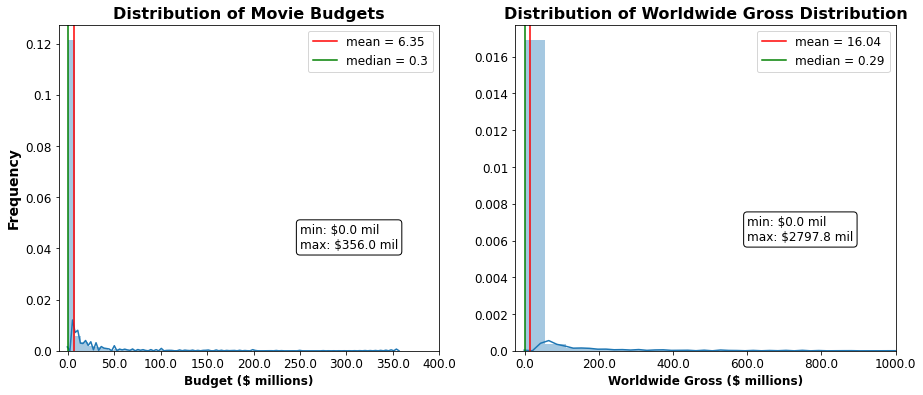

In [36]:
## set up figure and axes subplots
fig, axes = plt.subplots(1,2, figsize=(15,6))

ax1 = axes[0]
ax2 = axes[1]

## plot histogram showing distribution of movie budgets in millions of dollars
sns.distplot(financial_df['budget1mil'], ax=ax1)
ax1.set(xlim=(-10, 400))
ax1.set_title('Distribution of Movie Budgets', fontsize=16, weight='bold')

## plot lines showing the mean and median movies budgets
ax1.axvline(financial_df['budget1mil'].mean(), c='r', 
           label='mean = {}'.format(round(financial_df['budget1mil'].mean(), 2)))
ax1.axvline(financial_df['budget1mil'].median(), c='g', 
           label='median = {}'.format(round(financial_df['budget1mil'].median(), 2)))

ax1.set_ylabel('Frequency', fontsize=14, weight='bold')
ax1.set_xlabel('Budget ($ millions)', fontsize=12, weight='bold')
ax1.set_xticklabels(ax1.get_xticks(), fontsize=12)
ax1.set_yticklabels(ax1.get_yticks(), fontsize=12)
ax1.legend(fontsize=12)

## annotate subplot with min and max movie budgets
ax1.text(250, 0.04, 'min: ${} mil\nmax: ${} mil'.format(round(financial_df['budget1mil'].min(), 2), 
                                               round(financial_df['budget1mil'].max(), 2)), 
                                               fontsize=12, bbox=dict(boxstyle='round', fc='none'))

## plot histogram showing distribution of worldwide gross earnings in millions of dollars
sns.distplot(financial_df['ww_gross1mil'], ax=ax2)
ax2.set(xlim=(-25, 1000))
ax2.set_title('Distribution of Worldwide Gross Distribution', fontsize=16, weight='bold')

## plot lines showing the mean and median ww gross earnings
ax2.axvline(financial_df['ww_gross1mil'].mean(), c='r', 
           label='mean = {}'.format(round(financial_df['ww_gross1mil'].mean(), 2)))
ax2.axvline(financial_df['ww_gross1mil'].median(), c='g', 
           label='median = {}'.format(round(financial_df['ww_gross1mil'].median(), 2)))

ax2.set_xlabel('Worldwide Gross ($ millions)', fontsize=12, weight='bold')
ax2.set_xticklabels(ax2.get_xticks(), fontsize=12)
ax2.set_yticklabels(ax2.get_yticks(), fontsize=12)
ax2.legend(fontsize=12)

## annotate subplot with min and max ww gross earnings
ax2.text(600, 0.006, 'min: ${} mil\nmax: ${} mil'.format(round(financial_df['ww_gross1mil'].min(), 2), 
                                               round(financial_df['ww_gross1mil'].max(), 2)), 
                                               fontsize=12, bbox=dict(boxstyle='round', fc='none'))

Based on the histograms above, it is obvious that the data for both movie budget and worldwide gross are extremely skewed. As such, simply replacing all the missing values with a measure of central tendency such as the mean, median, or mode could inadvertently skew the results. The most cautious approach would be to drop rows that are missing information on budget and worldwide gross. Presumably the most popular and profitable movies would tend to have this information reported on IMDb. Those are the types of movies Microsoft would want to make, so it makes sense to focus the scope of our investigation on those types of movies.

In [37]:
## drop all rows with null values for budget or worldwide gross
## these values are necessary to calculate return on investment
financial_dropna = financial_df.dropna()
financial_dropna.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3263 entries, 6 to 30233
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   tconst         3263 non-null   object 
 1   primaryTitle   3263 non-null   object 
 2   startYear      3263 non-null   object 
 3   genres         3263 non-null   object 
 4   averageRating  3263 non-null   float64
 5   budget         3263 non-null   float64
 6   ww_gross       3263 non-null   float64
 7   budget1mil     3263 non-null   float64
 8   ww_gross1mil   3263 non-null   float64
dtypes: float64(5), object(4)
memory usage: 254.9+ KB


In [38]:
financial_dropna.describe()
## if we focus on 3rd and 4th quartile for ww gross, min would become $1.65 mil
## we are most interested in top performing movies
## we should also filter budgets
## being a large company, Microsoft will have resources to invest in making movies
## a budget of $1 mil or greater seems reasonable, and filtering like this would have the added benefit of 
## dropping impractical $0 budgets, allowing calc of ROI for every movie left in the data set
## (can't divide by zero)

,averageRating,budget,ww_gross,budget1mil,ww_gross1mil
count,3263.000000,3.263000e+03,3.263000e+03,3263.000000,3263.000000
mean,6.108612,1.971010e+07,5.549831e+07,19.710086,55.498226
std,1.134765,3.812692e+07,1.630340e+08,38.126918,163.033989
min,1.100000,0.000000e+00,1.300000e+01,0.000000,0.000000
25%,5.400000,1.200000e+06,9.162800e+04,1.200000,0.090000
50%,6.200000,5.000000e+06,1.647416e+06,5.000000,1.650000
75%,6.900000,2.000000e+07,3.022341e+07,20.000000,30.220000
max,9.500000,3.560000e+08,2.797801e+09,356.000000,2797.800000


In [39]:
## select a subset of the financial df without null values
med_financial_df = financial_dropna.loc[
    
    ## subset only contains rows with budgets >= $1 mil
    (financial_dropna['budget1mil']>=1) &
    
    ## and rows with ww_gross >= median
    (financial_dropna['ww_gross1mil']>=financial_dropna['ww_gross1mil'].median())
].reset_index()

## drop 'index' col
med_financial_df.drop(['index'], axis=1, inplace=True)

med_financial_df.head()

,tconst,primaryTitle,startYear,genres,averageRating,budget,ww_gross,budget1mil,ww_gross1mil
0,tt0337692,On the Road,2012,"Adventure,Drama,Romance",6.1,25000000.0,9.617377e+06,25.0,9.62
1,tt0359950,The Secret Life of Walter Mitty,2013,"Comedy,Drama,Fantasy",7.3,90000000.0,1.881333e+08,90.0,188.13
2,tt0365907,A Walk Among the Tombstones,2014,"Action,Crime,Drama",6.5,28000000.0,5.883438e+07,28.0,58.83
3,tt0369610,Jurassic World,2015,"Action,Adventure,Sci-Fi",7.0,150000000.0,1.670401e+09,150.0,1670.40
4,tt0376136,The Rum Diary,2011,"Comedy,Drama",6.2,45000000.0,3.013496e+07,45.0,30.13


In [40]:
med_financial_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1604 entries, 0 to 1603
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   tconst         1604 non-null   object 
 1   primaryTitle   1604 non-null   object 
 2   startYear      1604 non-null   object 
 3   genres         1604 non-null   object 
 4   averageRating  1604 non-null   float64
 5   budget         1604 non-null   float64
 6   ww_gross       1604 non-null   float64
 7   budget1mil     1604 non-null   float64
 8   ww_gross1mil   1604 non-null   float64
dtypes: float64(5), object(4)
memory usage: 112.9+ KB


In [41]:
med_financial_df.describe()

,averageRating,budget,ww_gross,budget1mil,ww_gross1mil
count,1604.000000,1.604000e+03,1.604000e+03,1604.000000,1604.000000
mean,6.279177,3.658362e+07,1.124804e+08,36.583579,112.480343
std,1.009705,4.849304e+07,2.183903e+08,48.493053,218.390315
min,1.300000,1.000000e+06,1.647416e+06,1.000000,1.650000
25%,5.700000,7.000000e+06,6.790422e+06,7.000000,6.787500
50%,6.400000,1.900000e+07,3.176146e+07,19.000000,31.760000
75%,7.000000,4.000000e+07,1.126424e+08,40.000000,112.640000
max,8.800000,3.560000e+08,2.797801e+09,356.000000,2797.800000


/Users/maxsteele/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
/Users/maxsteele/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
/Users/maxsteele/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator
/Users/maxsteele/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator


Text(800, 0.002, 'min: $1.65 mil\nmax: $2797.8 mil')

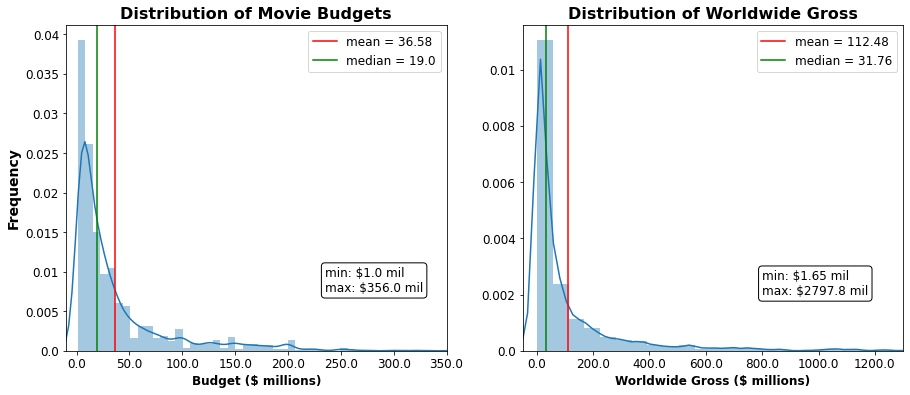

In [42]:
## set up figure and axes subplots
fig, axes = plt.subplots(1,2, figsize=(15,6))

ax1 = axes[0]
ax2 = axes[1]

## plot histogram showing distribution of movie budgets in millions of dollars
sns.distplot(med_financial_df['budget1mil'], ax=ax1)
ax1.set(xlim=(-10, 350))
ax1.set_title('Distribution of Movie Budgets', fontsize=16, weight='bold')

## plot lines showing the mean and median movies budgets
ax1.axvline(med_financial_df['budget1mil'].mean(), c='r', 
           label='mean = {}'.format(round(med_financial_df['budget1mil'].mean(), 2)))
ax1.axvline(med_financial_df['budget1mil'].median(), c='g', 
           label='median = {}'.format(round(med_financial_df['budget1mil'].median(), 2)))

ax1.set_ylabel('Frequency', fontsize=14, weight='bold')
ax1.set_xlabel('Budget ($ millions)', fontsize=12, weight='bold')
ax1.set_xticklabels(ax1.get_xticks(), fontsize=12)
ax1.set_yticklabels(ax1.get_yticks(), fontsize=12)
ax1.legend(fontsize=12)

## annotate subplot with min and max movie budgets
ax1.text(235, 0.0075, 'min: ${} mil\nmax: ${} mil'.format(round(med_financial_df['budget1mil'].min(), 2), 
                                               round(med_financial_df['budget1mil'].max(), 2)), 
                                               fontsize=12, bbox=dict(boxstyle='round', fc='none'))


## plot histogram showing distribution of worldwide gross earnings in millions of dollars
sns.distplot(med_financial_df['ww_gross1mil'], ax=ax2)
ax2.set(xlim=(-50, 1300))
ax2.set_title('Distribution of Worldwide Gross', fontsize=16, weight='bold')

## plot lines showing the mean and median ww gross earnings
ax2.axvline(med_financial_df['ww_gross1mil'].mean(), c='r', 
           label='mean = {}'.format(round(med_financial_df['ww_gross1mil'].mean(), 2)))
ax2.axvline(med_financial_df['ww_gross1mil'].median(), c='g', 
           label='median = {}'.format(round(med_financial_df['ww_gross1mil'].median(), 2)))

ax2.set_xlabel('Worldwide Gross ($ millions)', fontsize=12, weight='bold')
ax2.set_xticklabels(ax2.get_xticks(), fontsize=12)
ax2.set_yticklabels(ax2.get_yticks(), fontsize=12)
ax2.legend(fontsize=12)

## annotate subplot with min and max ww gross earnings
ax2.text(800, 0.002, 'min: ${} mil\nmax: ${} mil'.format(round(med_financial_df['ww_gross1mil'].min(), 2), 
                                               round(med_financial_df['ww_gross1mil'].max(), 2)), 
                                               fontsize=12, bbox=dict(boxstyle='round', fc='none'))

/Users/maxsteele/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  
/Users/maxsteele/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  from ipykernel import kernelapp as app


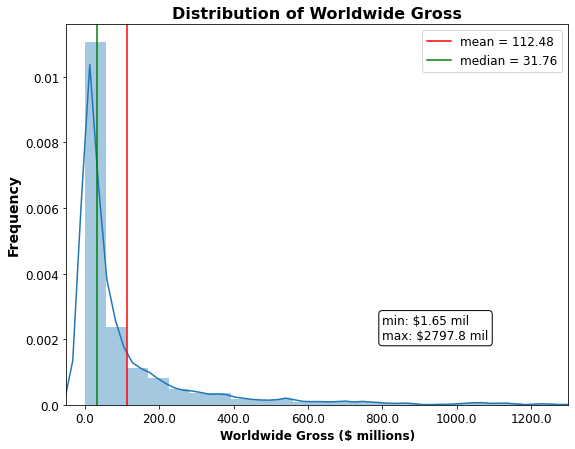

In [43]:
## plot histogram showing distribution of worldwide gross earnings in millions of dollars
ax = sns.distplot(med_financial_df['ww_gross1mil'])
ax.set(xlim=(-50, 1300))
ax.set_title('Distribution of Worldwide Gross', fontsize=16, weight='bold')

## plot lines showing the mean and median ww gross earnings
ax.axvline(med_financial_df['ww_gross1mil'].mean(), c='r', 
           label='mean = {}'.format(round(med_financial_df['ww_gross1mil'].mean(), 2)))
ax.axvline(med_financial_df['ww_gross1mil'].median(), c='g', 
           label='median = {}'.format(round(med_financial_df['ww_gross1mil'].median(), 2)))

ax.set_ylabel('Frequency', fontsize=14, weight='bold')
ax.set_xlabel('Worldwide Gross ($ millions)', fontsize=12, weight='bold')
ax.set_xticklabels(ax.get_xticks(), fontsize=12)
ax.set_yticklabels(ax.get_yticks(), fontsize=12)
ax.legend(fontsize=12)

## annotate subplot with min and max ww gross earnings
ax.text(800, 0.002, 'min: ${} mil\nmax: ${} mil'.format(round(med_financial_df['ww_gross1mil'].min(), 2), 
                                               round(med_financial_df['ww_gross1mil'].max(), 2)), 
                                               fontsize=12, bbox=dict(boxstyle='round', fc='none'))

ax.get_figure().set_size_inches((9,7))

In [44]:
## create a new column containing the return on investment for each movie
med_financial_df['numeratorROI'] = med_financial_df['ww_gross'] - med_financial_df['budget']
med_financial_df['ROI'] = (med_financial_df['numeratorROI'] / med_financial_df['budget']) * 100
med_financial_df.head()

,tconst,primaryTitle,startYear,genres,averageRating,budget,ww_gross,budget1mil,ww_gross1mil,numeratorROI,ROI
0,tt0337692,On the Road,2012,"Adventure,Drama,Romance",6.1,25000000.0,9.617377e+06,25.0,9.62,-1.538262e+07,-61.530492
1,tt0359950,The Secret Life of Walter Mitty,2013,"Comedy,Drama,Fantasy",7.3,90000000.0,1.881333e+08,90.0,188.13,9.813332e+07,109.037024
2,tt0365907,A Walk Among the Tombstones,2014,"Action,Crime,Drama",6.5,28000000.0,5.883438e+07,28.0,58.83,3.083438e+07,110.122800
3,tt0369610,Jurassic World,2015,"Action,Adventure,Sci-Fi",7.0,150000000.0,1.670401e+09,150.0,1670.40,1.520401e+09,1013.600425
4,tt0376136,The Rum Diary,2011,"Comedy,Drama",6.2,45000000.0,3.013496e+07,45.0,30.13,-1.486504e+07,-33.033427


In [45]:
## create 'genre_list' col where the genres are contained in a list rather than one long string
med_financial_df['genre_list'] = med_financial_df['genres'].apply(lambda x: x.split(','))

print(type(med_financial_df['genre_list'][0]))
med_financial_df['genre_list'][0]

<class 'list'>


['Adventure', 'Drama', 'Romance']

In [46]:
## need to create a column for each genre to be filled w/ boolean values based on the genre(s) of ea movie

## join all genres in the 'genres' col into one long string
all_genres_string = ','.join(med_financial_df['genres'])

## split that string by commas, use set() to return only unique values, make those values into a list
all_genres_list = list(set(all_genres_string.split(',')))
all_genres_list

['History',
 'Mystery',
 'Western',
 'Fantasy',
 'Drama',
 'Horror',
 'Documentary',
 'Comedy',
 'Thriller',
 'Music',
 'Sport',
 'Biography',
 'Romance',
 'Sci-Fi',
 'Crime',
 'Family',
 'Adventure',
 'Action',
 'Musical',
 'Animation',
 'War']

In [47]:
## use ea item in the list to make cols in df and fill that column with boolean if is/is not that genre
for genre in all_genres_list:
    med_financial_df[genre] = med_financial_df['genres'].str.contains(genre)

In [48]:
## add a column for the number of genres a movie spans

## new 'genre_count' col is filled with the sum of all T/F values across all the genre cols for that row
## (axis=1 specifies to add across the row rather than down the col)
med_financial_df['genre_count'] = med_financial_df[all_genres_list].sum(axis=1)

## convert startYear into integers
med_financial_df['startYear'] = med_financial_df['startYear'].astype(int)

med_financial_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1604 entries, 0 to 1603
Data columns (total 34 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   tconst         1604 non-null   object 
 1   primaryTitle   1604 non-null   object 
 2   startYear      1604 non-null   int64  
 3   genres         1604 non-null   object 
 4   averageRating  1604 non-null   float64
 5   budget         1604 non-null   float64
 6   ww_gross       1604 non-null   float64
 7   budget1mil     1604 non-null   float64
 8   ww_gross1mil   1604 non-null   float64
 9   numeratorROI   1604 non-null   float64
 10  ROI            1604 non-null   float64
 11  genre_list     1604 non-null   object 
 12  History        1604 non-null   bool   
 13  Mystery        1604 non-null   bool   
 14  Western        1604 non-null   bool   
 15  Fantasy        1604 non-null   bool   
 16  Drama          1604 non-null   bool   
 17  Horror         1604 non-null   bool   
 18  Document

In [49]:
## create a new df that explodes each movie record into multiple rows for each genre it falls into
financial_explode_genre = med_financial_df.explode('genre_list') 
financial_explode_genre.head()

,tconst,primaryTitle,startYear,genres,averageRating,budget,ww_gross,budget1mil,ww_gross1mil,numeratorROI,...,Romance,Sci-Fi,Crime,Family,Adventure,Action,Musical,Animation,War,genre_count
0,tt0337692,On the Road,2012,"Adventure,Drama,Romance",6.1,25000000.0,9617377.0,25.0,9.62,-15382623.0,...,True,False,False,False,True,False,False,False,False,3
0,tt0337692,On the Road,2012,"Adventure,Drama,Romance",6.1,25000000.0,9617377.0,25.0,9.62,-15382623.0,...,True,False,False,False,True,False,False,False,False,3
0,tt0337692,On the Road,2012,"Adventure,Drama,Romance",6.1,25000000.0,9617377.0,25.0,9.62,-15382623.0,...,True,False,False,False,True,False,False,False,False,3
1,tt0359950,The Secret Life of Walter Mitty,2013,"Comedy,Drama,Fantasy",7.3,90000000.0,188133322.0,90.0,188.13,98133322.0,...,False,False,False,False,False,False,False,False,False,3
1,tt0359950,The Secret Life of Walter Mitty,2013,"Comedy,Drama,Fantasy",7.3,90000000.0,188133322.0,90.0,188.13,98133322.0,...,False,False,False,False,False,False,False,False,False,3


# Q1: Which genres are top grossing worldwide and have the highest return on investment?

In [50]:
## make a dataframe displaying the means for all cols grouped by individual genres
all_genres_means = financial_explode_genre.groupby('genre_list').mean()
all_genres_means

,startYear,averageRating,budget,ww_gross,budget1mil,ww_gross1mil,numeratorROI,ROI,History,Mystery,...,Romance,Sci-Fi,Crime,Family,Adventure,Action,Musical,Animation,War,genre_count
genre_list,,,,,,,,,,,,,,,,,,,,,
Action,2014.222958,6.307506,6.650728e+07,2.002771e+08,66.507241,200.277196,1.337699e+08,165.268791,0.026490,0.024283,...,0.017660,0.158940,0.240618,0.028698,0.481236,1.000000,0.000000,0.052980,0.015453,2.911700
Adventure,2014.634961,6.268895,8.070955e+07,2.677183e+08,80.709537,267.718252,1.870087e+08,184.098049,0.010283,0.012853,...,0.007712,0.136247,0.053985,0.143959,1.000000,0.560411,0.000000,0.277635,0.002571,2.958869
Animation,2014.492063,6.288889,6.297082e+07,2.067320e+08,62.970873,206.732143,1.437612e+08,179.193330,0.000000,0.000000,...,0.000000,0.000000,0.015873,0.198413,0.857143,0.190476,0.000000,1.000000,0.000000,2.928571
Biography,2014.711409,6.878523,2.075240e+07,5.217694e+07,20.752416,52.176644,3.142454e+07,159.208902,0.161074,0.000000,...,0.073826,0.000000,0.127517,0.046980,0.040268,0.053691,0.006711,0.000000,0.006711,2.778523
Comedy,2014.361386,6.034323,3.117767e+07,9.374557e+07,31.177624,93.745462,6.256790e+07,186.755062,0.004950,0.014851,...,0.206271,0.018152,0.095710,0.094059,0.224422,0.143564,0.006601,0.125413,0.000000,2.400990
Crime,2014.593361,6.405809,2.612802e+07,6.169305e+07,26.127967,61.693029,3.556503e+07,117.729745,0.020747,0.103734,...,0.020747,0.008299,1.000000,0.004149,0.087137,0.452282,0.004149,0.008299,0.004149,2.875519
Documentary,2013.666667,7.053333,8.010759e+06,2.425956e+07,8.010667,24.260000,1.624880e+07,228.854907,0.133333,0.000000,...,0.000000,0.000000,0.066667,0.066667,0.066667,0.066667,0.000000,0.000000,0.066667,1.800000
Drama,2014.377382,6.608767,2.388884e+07,6.941406e+07,23.888793,69.413964,4.552522e+07,192.999400,0.082592,0.074968,...,0.185515,0.030496,0.172808,0.045743,0.081321,0.172808,0.003812,0.006353,0.033037,2.608640
Family,2014.515385,6.002308,4.637540e+07,1.332098e+08,46.375308,133.209538,8.683441e+07,155.624111,0.000000,0.007692,...,0.015385,0.000000,0.007692,1.000000,0.430769,0.100000,0.007692,0.192308,0.000000,2.753846


In [51]:
financial_explode_genre.head()

,tconst,primaryTitle,startYear,genres,averageRating,budget,ww_gross,budget1mil,ww_gross1mil,numeratorROI,...,Romance,Sci-Fi,Crime,Family,Adventure,Action,Musical,Animation,War,genre_count
0,tt0337692,On the Road,2012,"Adventure,Drama,Romance",6.1,25000000.0,9617377.0,25.0,9.62,-15382623.0,...,True,False,False,False,True,False,False,False,False,3
0,tt0337692,On the Road,2012,"Adventure,Drama,Romance",6.1,25000000.0,9617377.0,25.0,9.62,-15382623.0,...,True,False,False,False,True,False,False,False,False,3
0,tt0337692,On the Road,2012,"Adventure,Drama,Romance",6.1,25000000.0,9617377.0,25.0,9.62,-15382623.0,...,True,False,False,False,True,False,False,False,False,3
1,tt0359950,The Secret Life of Walter Mitty,2013,"Comedy,Drama,Fantasy",7.3,90000000.0,188133322.0,90.0,188.13,98133322.0,...,False,False,False,False,False,False,False,False,False,3
1,tt0359950,The Secret Life of Walter Mitty,2013,"Comedy,Drama,Fantasy",7.3,90000000.0,188133322.0,90.0,188.13,98133322.0,...,False,False,False,False,False,False,False,False,False,3


In [52]:
## calculate mean and median ww gross in million of dollars for all movies
all_mean_wwg1mil = financial_explode_genre['ww_gross1mil'].mean()
all_median_wwg1mil = financial_explode_genre['ww_gross1mil'].median()

## calculate mean and median ROI for all movies
all_mean_ROI = financial_explode_genre['ROI'].mean()
all_median_ROI = financial_explode_genre['ROI'].median()

In [53]:
## make a list of genre names to adjust for tick labels
list(financial_explode_genre['genre_list'].unique())

['Adventure',
 'Drama',
 'Romance',
 'Comedy',
 'Fantasy',
 'Action',
 'Crime',
 'Sci-Fi',
 'Animation',
 'Family',
 'Mystery',
 'History',
 'War',
 'Thriller',
 'Horror',
 'Biography',
 'Sport',
 'Music',
 'Documentary',
 'Western',
 'Musical']

In [54]:
## shorten longer genre names to fix spacing on axis labels
all_genre_xlabels = ['Adventure',
                     'Drama',
                     'Romance',
                     'Comedy',
                     'Fantasy',
                     'Action',
                     'Crime',
                     'Sci-Fi',
                     'Animation',
                     'Family',
                     'Mystery',
                     'History',
                     'War',
                     'Thriller',
                     'Horror',
                     'Bio',
                     'Sport',
                     'Music',
                     'Doc',
                     'Western',
                     'Musical']

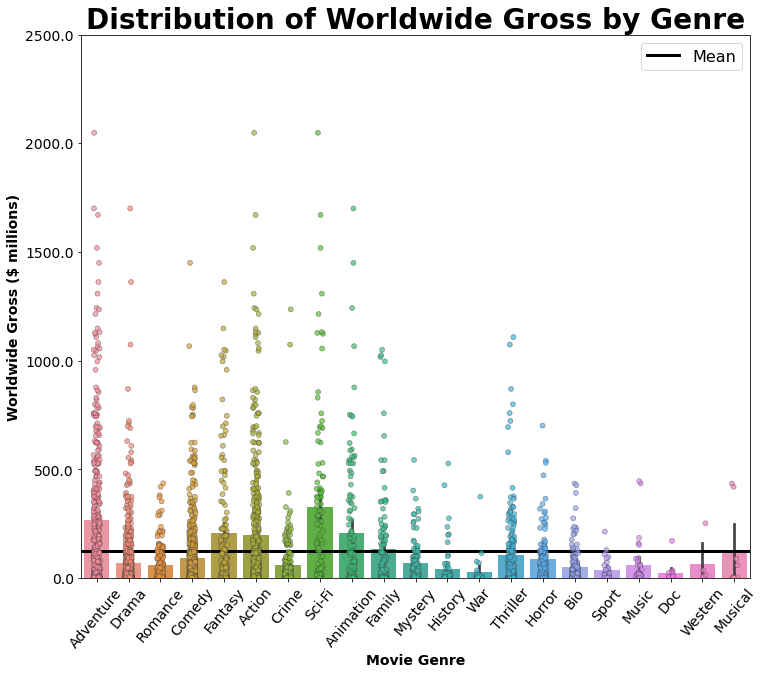

In [55]:
## make a bar plot showing distribution of ww gross earnings by movie genre for all genres
ax = sns.barplot(x="genre_list", y="ww_gross1mil", data=financial_explode_genre,
                 linewidth=1)

## plot a strip plot of the same data on top of the bar plot
ax = sns.stripplot(x="genre_list", y="ww_gross1mil", data=financial_explode_genre,
                  linewidth=0.5, alpha=0.7)

## plot horizontal lines for the mean and median ww gross earnings for all movies
ax.axhline(y=all_mean_wwg1mil, ls='-', c='k', linewidth=3, label='Mean')
# ax.axhline(y=all_median_wwg1mil, ls='--', c='k', linewidth=3, label='Median')

ax.set(ylim=(0, 2500))
ax.set_xticklabels(all_genre_xlabels, rotation=50, fontsize=14)
ax.set_xlabel('Movie Genre', fontsize=14, weight='bold')
ax.set_ylabel('Worldwide Gross ($ millions)', fontsize=14, weight='bold')
ax.set_yticks(ax.get_yticks())
ax.set_yticklabels(ax.get_yticks(), fontsize=14)
ax.set_title('Distribution of Worldwide Gross by Genre', fontsize=28, weight='bold')
plt.legend(fontsize=16)
ax.get_figure().set_size_inches((12,10))

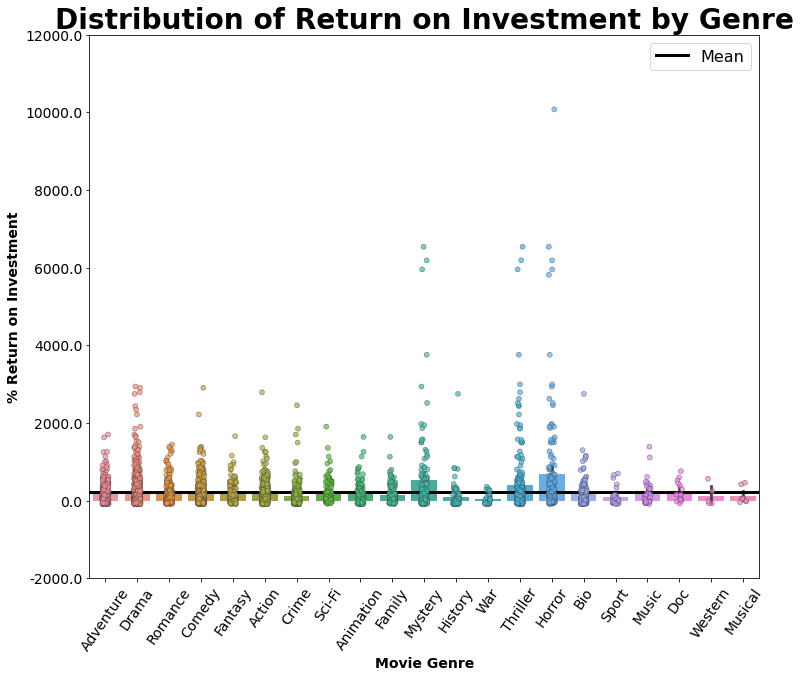

In [56]:
## make a bar plot showing distribution of ROI by movie genre for all genres
ax = sns.barplot(x="genre_list", y="ROI", data=financial_explode_genre,
                 linewidth=1)

## plot a strip plot of the same data on top of the bar plot
ax = sns.stripplot(x="genre_list", y="ROI", data=financial_explode_genre,
                  linewidth=0.5, alpha=0.7)

## plot horizontal lines for the mean and median ROI for all movies
ax.axhline(y=all_mean_ROI, ls='-', c='k', linewidth=3, label='Mean')
# ax.axhline(y=all_median_ROI, ls='--', c='k', linewidth=3, label='Median')

ax.set(ylim=(-1000, 12000))
ax.set_xticklabels(all_genre_xlabels, rotation=55, fontsize=14)
ax.set_xlabel('Movie Genre', fontsize=14, weight='bold')
ax.set_ylabel('% Return on Investment', fontsize=14, weight='bold')
ax.set_yticks(ax.get_yticks())
ax.set_yticklabels(ax.get_yticks(), fontsize=14)
ax.set_title('Distribution of Return on Investment by Genre', fontsize=28, weight='bold')
plt.legend(fontsize=16)
ax.get_figure().set_size_inches((12,10))

In [57]:
## create dataframe that summarizes mean values for ea genre
mean_group = financial_explode_genre.groupby('genre_list').mean()

## create dataframe that summarizes median values for ea genre
median_group = financial_explode_genre.groupby('genre_list').median()

In [58]:
## find the genres that have mean ww_gross above the median
mean_wwg_topHalf = mean_group.loc[mean_group['ww_gross1mil']>=mean_group['ww_gross1mil'].quantile(0.50)]
mean_wwg_topHalf.index

Index(['Action', 'Adventure', 'Animation', 'Comedy', 'Family', 'Fantasy',
       'Horror', 'Musical', 'Mystery', 'Sci-Fi', 'Thriller'],
      dtype='object', name='genre_list')

In [59]:
## find the genres that have median ww_gross above the median
median_wwg_topHalf = median_group.loc[median_group['ww_gross1mil']>=median_group['ww_gross1mil'].quantile(0.50)]
median_wwg_topHalf.index

Index(['Action', 'Adventure', 'Animation', 'Comedy', 'Family', 'Fantasy',
       'Horror', 'Musical', 'Mystery', 'Sci-Fi', 'Thriller'],
      dtype='object', name='genre_list')

In [60]:
## find the genres that have mean ROI above the median
mean_ROI_topHalf = mean_group.loc[mean_group['ROI']>=mean_group['ROI'].quantile(0.50)]
mean_ROI_topHalf.index

Index(['Adventure', 'Animation', 'Comedy', 'Documentary', 'Drama', 'Horror',
       'Music', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller'],
      dtype='object', name='genre_list')

In [61]:
## find the genres that have median ROI above the median
median_ROI_topHalf = median_group.loc[median_group['ROI']>=median_group['ROI'].quantile(0.50)]
median_ROI_topHalf.index

Index(['Action', 'Adventure', 'Animation', 'Comedy', 'Documentary', 'Fantasy',
       'Horror', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller'],
      dtype='object', name='genre_list')

In [62]:
## make a list of top genres by mean ww_gross
mean_wwg_topHalf_list = list(mean_wwg_topHalf.index)

## make a list of top genres by mean ROI
mean_ROI_topHalf_list = list(mean_ROI_topHalf.index)

## make a list of top genres by ww_gross
median_wwg_topHalf_list = list(median_wwg_topHalf.index)

## make a list of top genres by ROI
median_ROI_topHalf_list = list(median_ROI_topHalf.index)


## add the lists together and pick out the genres that fall in all categories
topH_genres = (mean_wwg_topHalf_list + mean_ROI_topHalf_list +
               median_wwg_topHalf_list + median_ROI_topHalf_list)
topH_counts = pd.Series(topH_genres).value_counts()
topH_counts

Mystery        4
Adventure      4
Thriller       4
Comedy         4
Sci-Fi         4
Animation      4
Horror         4
Fantasy        3
Action         3
Family         2
Romance        2
Documentary    2
Musical        2
Drama          1
Music          1
dtype: int64

In [63]:
## make a list of genres that fall in both categories (top ww gross and top ROI)
top_genre_list = list(topH_counts[:7].index)
print(top_genre_list)
len(top_genre_list)

['Mystery', 'Adventure', 'Thriller', 'Comedy', 'Sci-Fi', 'Animation', 'Horror']


7

In [64]:
## give a set order to this list so it doesn't take a random order every time I re-run this notebook
top_genre_list = ['Thriller', 'Comedy', 'Adventure', 'Mystery', 'Horror', 'Animation', 'Sci-Fi']

In [65]:
### only add movies to new df that fall into at least one of the top 8 genres
top_genres_df = med_financial_df.loc[(med_financial_df['Adventure'] == True) | 
                                 (med_financial_df['Mystery'] == True) |
                                 (med_financial_df['Animation'] == True) |
                                 (med_financial_df['Sci-Fi'] == True) |
                                 (med_financial_df['Thriller'] == True) |
                                 (med_financial_df['Comedy'] == True) |
                                 (med_financial_df['Horror'] == True) 
                                ]

## check out new top genres df                            
display(top_genres_df.shape, top_genres_df.head())

(1195, 34)

,tconst,primaryTitle,startYear,genres,averageRating,budget,ww_gross,budget1mil,ww_gross1mil,numeratorROI,...,Romance,Sci-Fi,Crime,Family,Adventure,Action,Musical,Animation,War,genre_count
0,tt0337692,On the Road,2012,"Adventure,Drama,Romance",6.1,25000000.0,9.617377e+06,25.0,9.62,-1.538262e+07,...,True,False,False,False,True,False,False,False,False,3
1,tt0359950,The Secret Life of Walter Mitty,2013,"Comedy,Drama,Fantasy",7.3,90000000.0,1.881333e+08,90.0,188.13,9.813332e+07,...,False,False,False,False,False,False,False,False,False,3
3,tt0369610,Jurassic World,2015,"Action,Adventure,Sci-Fi",7.0,150000000.0,1.670401e+09,150.0,1670.40,1.520401e+09,...,False,True,False,False,True,True,False,False,False,3
4,tt0376136,The Rum Diary,2011,"Comedy,Drama",6.2,45000000.0,3.013496e+07,45.0,30.13,-1.486504e+07,...,False,False,False,False,False,False,False,False,False,2
5,tt0377981,Gnomeo & Juliet,2011,"Adventure,Animation,Comedy",5.9,36000000.0,1.939677e+08,36.0,193.97,1.579677e+08,...,False,False,False,False,True,False,False,True,False,3


In [66]:
## drop genre columns from df that don't correspond to one of the top 8 genres
top_genres_df = top_genres_df.drop(['numeratorROI', 'Music', 'Musical', 'Crime', 'Fantasy', 'Western', 'Family', 
               'Biography', 'History', 'War', 'Documentary', 'Sport', 
               'Romance', 'Drama', 'Horror', 'Action'], axis=1)
top_genres_df.head()

,tconst,primaryTitle,startYear,genres,averageRating,budget,ww_gross,budget1mil,ww_gross1mil,ROI,genre_list,Mystery,Comedy,Thriller,Sci-Fi,Adventure,Animation,genre_count
0,tt0337692,On the Road,2012,"Adventure,Drama,Romance",6.1,25000000.0,9.617377e+06,25.0,9.62,-61.530492,"[Adventure, Drama, Romance]",False,False,False,False,True,False,3
1,tt0359950,The Secret Life of Walter Mitty,2013,"Comedy,Drama,Fantasy",7.3,90000000.0,1.881333e+08,90.0,188.13,109.037024,"[Comedy, Drama, Fantasy]",False,True,False,False,False,False,3
3,tt0369610,Jurassic World,2015,"Action,Adventure,Sci-Fi",7.0,150000000.0,1.670401e+09,150.0,1670.40,1013.600425,"[Action, Adventure, Sci-Fi]",False,False,False,True,True,False,3
4,tt0376136,The Rum Diary,2011,"Comedy,Drama",6.2,45000000.0,3.013496e+07,45.0,30.13,-33.033427,"[Comedy, Drama]",False,True,False,False,False,False,2
5,tt0377981,Gnomeo & Juliet,2011,"Adventure,Animation,Comedy",5.9,36000000.0,1.939677e+08,36.0,193.97,438.799083,"[Adventure, Animation, Comedy]",False,True,False,False,True,True,3


In [67]:
## define a function to filter out non-top genres from the genre list column
def fix_genre(genres):
    """ take in a string of genres, split it by commas into a list, and only append genres from 
    top_genre_list to a new list of genres
    Source for code: written by Sam Stoltenberg - github.com/skelouse
    """
    new_genres = []
    genres = genres.split(',')
    for g in genres:
        if g in top_genre_list:
            new_genres.append(g)
    return new_genres

In [68]:
## create a new col in the df that filters out all non-top genres from the genre list
top_genres_df['top_genre_list'] = top_genres_df['genres'].apply(lambda x: fix_genre(x))
display(top_genres_df.shape, top_genres_df.head())

(1195, 19)

,tconst,primaryTitle,startYear,genres,averageRating,budget,ww_gross,budget1mil,ww_gross1mil,ROI,genre_list,Mystery,Comedy,Thriller,Sci-Fi,Adventure,Animation,genre_count,top_genre_list
0,tt0337692,On the Road,2012,"Adventure,Drama,Romance",6.1,25000000.0,9.617377e+06,25.0,9.62,-61.530492,"[Adventure, Drama, Romance]",False,False,False,False,True,False,3,[Adventure]
1,tt0359950,The Secret Life of Walter Mitty,2013,"Comedy,Drama,Fantasy",7.3,90000000.0,1.881333e+08,90.0,188.13,109.037024,"[Comedy, Drama, Fantasy]",False,True,False,False,False,False,3,[Comedy]
3,tt0369610,Jurassic World,2015,"Action,Adventure,Sci-Fi",7.0,150000000.0,1.670401e+09,150.0,1670.40,1013.600425,"[Action, Adventure, Sci-Fi]",False,False,False,True,True,False,3,"[Adventure, Sci-Fi]"
4,tt0376136,The Rum Diary,2011,"Comedy,Drama",6.2,45000000.0,3.013496e+07,45.0,30.13,-33.033427,"[Comedy, Drama]",False,True,False,False,False,False,2,[Comedy]
5,tt0377981,Gnomeo & Juliet,2011,"Adventure,Animation,Comedy",5.9,36000000.0,1.939677e+08,36.0,193.97,438.799083,"[Adventure, Animation, Comedy]",False,True,False,False,True,True,3,"[Adventure, Animation, Comedy]"


In [69]:
## explode the dataframe by this new top_genre_list col to be able to group by only top genres,
 ## not by all genres
explode_top_genres = top_genres_df.explode('top_genre_list') 
explode_top_genres.head()

,tconst,primaryTitle,startYear,genres,averageRating,budget,ww_gross,budget1mil,ww_gross1mil,ROI,genre_list,Mystery,Comedy,Thriller,Sci-Fi,Adventure,Animation,genre_count,top_genre_list
0,tt0337692,On the Road,2012,"Adventure,Drama,Romance",6.1,25000000.0,9.617377e+06,25.0,9.62,-61.530492,"[Adventure, Drama, Romance]",False,False,False,False,True,False,3,Adventure
1,tt0359950,The Secret Life of Walter Mitty,2013,"Comedy,Drama,Fantasy",7.3,90000000.0,1.881333e+08,90.0,188.13,109.037024,"[Comedy, Drama, Fantasy]",False,True,False,False,False,False,3,Comedy
3,tt0369610,Jurassic World,2015,"Action,Adventure,Sci-Fi",7.0,150000000.0,1.670401e+09,150.0,1670.40,1013.600425,"[Action, Adventure, Sci-Fi]",False,False,False,True,True,False,3,Adventure
3,tt0369610,Jurassic World,2015,"Action,Adventure,Sci-Fi",7.0,150000000.0,1.670401e+09,150.0,1670.40,1013.600425,"[Action, Adventure, Sci-Fi]",False,False,False,True,True,False,3,Sci-Fi
4,tt0376136,The Rum Diary,2011,"Comedy,Drama",6.2,45000000.0,3.013496e+07,45.0,30.13,-33.033427,"[Comedy, Drama]",False,True,False,False,False,False,2,Comedy


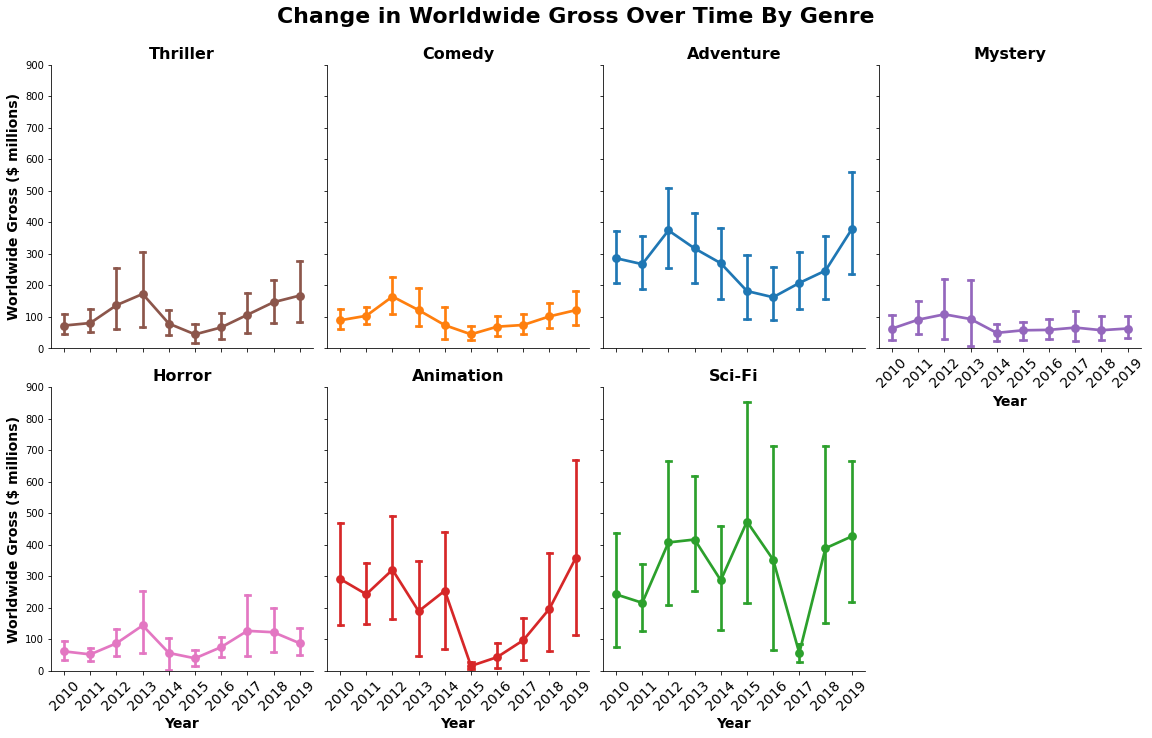

In [70]:
## make a point plot for each top genre showing how ww gross earnings have changed over time
g = sns.catplot(x="startYear", y="ww_gross1mil", col="top_genre_list", col_wrap=4,
                capsize=.2, height=5, aspect=.8, col_order=top_genre_list,
                kind="point", hue="top_genre_list", data=explode_top_genres)

g.set(ylim=(0, 900))

## collapse the array of axes into 1 dimension so it's easy to iterate through
axes = g.axes.flatten()

## iterate through each genre in the list used to order the plots
 ## and assign that genre's name as the title of the subplot with the same index
for i, genre in enumerate(top_genre_list):
    axes[i].set_title(genre, fontsize=16, weight='bold')
    
axes[0].set_ylabel('Worldwide Gross ($ millions)', fontsize='14', weight='bold')
axes[4].set_ylabel('Worldwide Gross ($ millions)', fontsize='14', weight='bold')

for ax in axes[3:]:
    ax.set_xlabel('Year', fontsize='14', weight='bold')

g.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=14)

g.fig.suptitle("Change in Worldwide Gross Over Time By Genre", size=22, weight='bold')
g.fig.subplots_adjust(top=.9)

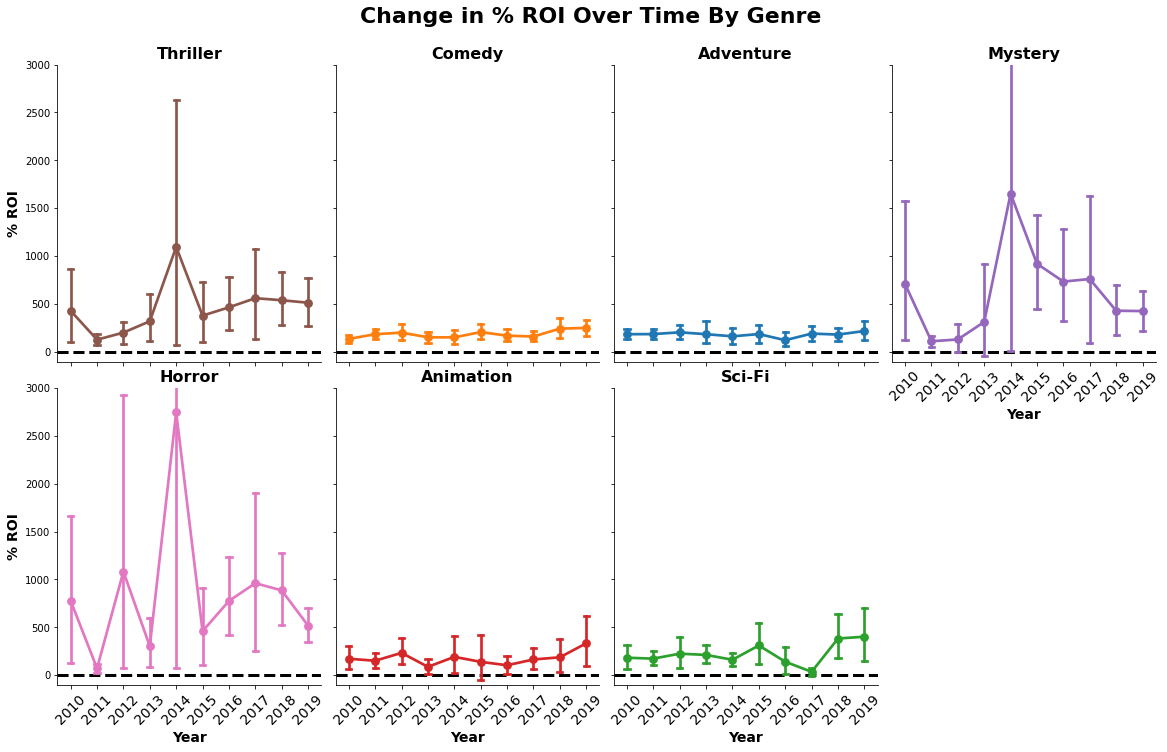

In [71]:
## make a point plot for each top genre showing how ROI has changed over time
g = sns.catplot(x="startYear", y="ROI", col="top_genre_list", col_wrap=4,
                capsize=.2, height=5, aspect=.8, col_order=top_genre_list,
                kind="point", hue="top_genre_list", data=explode_top_genres)

## plot a horizontal line at ROI = 0 to emphasize negative ROIs
g.map(plt.axhline, y=0, ls='--', c='k', linewidth=3).set(ylim=(-100, 3000))

## collapse the array of axes into 1 dimension so it's easy to iterate through
axes = g.axes.flatten()

## iterate through each genre in the list used to order the plots
 ## and assign that genre's name as the title of the subplot with the same index
for i, genre in enumerate(top_genre_list):
    axes[i].set_title(genre, fontsize=16, weight='bold')

axes[0].set_ylabel('% ROI', fontsize='14', weight='bold')
axes[4].set_ylabel('% ROI', fontsize='14', weight='bold')

for ax in axes[3:]:
    ax.set_xlabel('Year', fontsize='14', weight='bold')

g.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=14)

g.fig.suptitle("Change in % ROI Over Time By Genre", size=22, weight='bold')
g.fig.subplots_adjust(top=.9)

In [72]:
## calculate mean and median ww gross earnings for only top genres
top_mean_wwg1mil = explode_top_genres['ww_gross1mil'].mean()
top_median_wwg1mil = explode_top_genres['ww_gross1mil'].median()

## calculate mean and median ROI for only top genres
top_mean_ROI = explode_top_genres['ROI'].mean()
top_median_ROI = explode_top_genres['ROI'].median()

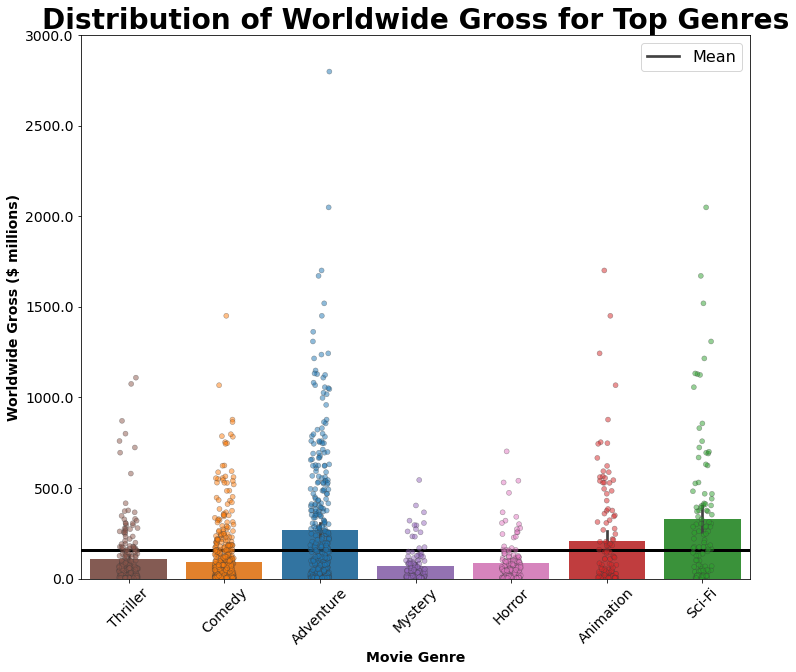

In [73]:
## make a bar plot showing distribution of ww gross earnings by movie genre for top genres
ax = sns.barplot(x="top_genre_list", y="ww_gross1mil", order=top_genre_list,
                 hue="top_genre_list", data=explode_top_genres,
                 dodge=False)

## plot a strip plot of the same data on top of the bar plot
ax = sns.stripplot(x='top_genre_list', y="ww_gross1mil", order=top_genre_list,
                   data=explode_top_genres, hue="top_genre_list",
                   linewidth=0.5, alpha=0.5)

## plot horizontal lines for the mean and median ww gross earnings for top genres
ax.axhline(y=top_mean_wwg1mil, ls='-', c='k', linewidth=3, label='Mean')
# ax.axhline(y=top_median_wwg1mil, ls='--', c='k', linewidth=3, label='Median')

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=14)
ax.set_xlabel('Movie Genre', fontsize=14, weight='bold')
ax.set_ylabel('Worldwide Gross ($ millions)', fontsize=14, weight='bold')
ax.set_yticks(ax.get_yticks())
ax.set(ylim=(0, 3000))
ax.set_yticklabels(ax.get_yticks(), fontsize=14)
ax.set_title('Distribution of Worldwide Gross for Top Genres', fontsize=28, weight='bold')
plt.legend(fontsize=16, labels=['Mean'], loc='upper right')
ax.get_figure().set_size_inches((12,10))

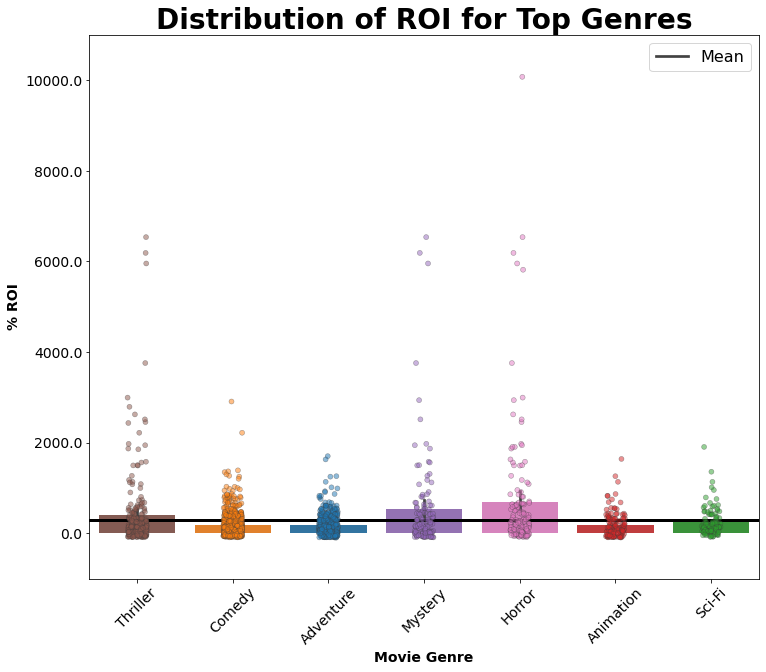

In [74]:
## make a bar plot showing distribution of ROI by movie genre for top genres
ax = sns.barplot(x="top_genre_list", y="ROI", order=top_genre_list,
                 data=explode_top_genres, hue="top_genre_list",
                 dodge=False)

## plot a strip plot of the same data on top of the bar plot
ax = sns.stripplot(x='top_genre_list', y="ROI", order=top_genre_list,
                   data=explode_top_genres, hue="top_genre_list",
                   linewidth=0.5, alpha=0.5)

## plot horizontal lines for the mean and median ROI for top genres
ax.axhline(y=top_mean_ROI, ls='-', c='k', linewidth=3, label='Mean')
# ax.axhline(y=top_median_ROI, ls='--', c='k', linewidth=3, label='Median')

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=14)
ax.set_xlabel('Movie Genre', fontsize=14, weight='bold')
ax.set_ylabel('% ROI', fontsize=14, weight='bold')
ax.set_yticks(ax.get_yticks())
ax.set(ylim=(-1000, 11000))
ax.set_yticklabels(ax.get_yticks(), fontsize=14)
ax.set_title('Distribution of ROI for Top Genres', fontsize=28, weight='bold')
plt.legend(fontsize=16, labels=['Mean'], loc='upper right')
ax.get_figure().set_size_inches((12,10))

Based on my analysis, I found that movie genres vary widely in terms of both worldwide gross earnings and return on investment. Genres with top worldwide gross earnings that stuck out initially were Adventure, Drama, Action, and Sci-Fi. Return on investment appears to be more consistent within and across genres than worldwide gross earnings. Three genres stuck out clearly as genres where extremely profitable movies can be made on a relatively low budget: Mystery, Thriller, and Horror.

Overall the most consistently high performing genres based on worldwide gross earnings and return on investment are:
- Comedy
* Animation
* Horror
* Adventure
* Thriller
* Mystery
* Sci-Fi

Within this subset of genres, I found that Adventure movies have had the most consistently high worldwide gross earnings since 2010. Animation and Sci-Fi have also had high gross earnings since 2010, but these categories are less consistent than Adventure. In terms of return on investment, Mystery, Thriller, and Horror are all genres in which it is possible to make quite a lot of profit for relatively little investment. However, this trend is not necessarily the norm and appears to vary substantially from year to year. Additionally, while all 7 top genres present relatively low risk of losing money, Animation, Horror, Thriller, and Sci-Fi seem to present the most risk of a negative return on investment. Comedy and Adventure movies have seen steady return on investment since 2010 and seem to present relatively low risk. Even though Animation and Sci-Fi movies appear to be riskier investments, it is worth nothing that both have started to see increasing returns over Adventure and Comedy in the past couple years.

In light of these insights, I would recommend Microsoft's primary focus be on Adventure movies because they have the potential to be extremely high grossing and are most consistent in providing a positive return on investment. It likely would not be wise to produce movies of only a single genre given the diversity of entertainment options available in today's world. As such I would recommend that the studio consider producing some Comedy movies which are also relatively low risk. The studio should also consider producing some Animation and/or Sci-Fi movies as these genres appear to be on the rise. However they are less consistent than the other two genres, so they should not be the main focus of the studio, at least as it starts out.

# Q2: Of the top genres, how does movie budget affect metrics of financial success?

In [75]:
## check out mean budgets of top genres
top_g_means = explode_top_genres.groupby('top_genre_list').mean()
top_g_means['budget1mil']
mean_budget_dict = dict(zip(top_g_means.index, round(top_g_means['budget1mil'],2 )))
mean_budget_dict

{'Adventure': 80.71,
 'Animation': 62.97,
 'Comedy': 31.18,
 'Horror': 19.76,
 'Mystery': 20.3,
 'Sci-Fi': 94.31,
 'Thriller': 28.99}

In [76]:
## check out median budgets of top genres
top_g_medians = explode_top_genres.groupby('top_genre_list').median()
top_g_medians['budget1mil']
median_budget_dict = dict(zip(top_g_medians.index, top_g_medians['budget1mil']))
median_budget_dict

{'Adventure': 60.0,
 'Animation': 39.5,
 'Comedy': 17.0,
 'Horror': 10.0,
 'Mystery': 11.505,
 'Sci-Fi': 74.0,
 'Thriller': 19.0}

In [77]:
## create separate DataFrames for each of the top genres
adventure_df = explode_top_genres.loc[explode_top_genres['top_genre_list']=='Adventure']
mystery_df = explode_top_genres.loc[explode_top_genres['top_genre_list']=='Mystery']
animation_df = explode_top_genres.loc[explode_top_genres['top_genre_list']=='Animation']
scifi_df = explode_top_genres.loc[explode_top_genres['top_genre_list']=='Sci-Fi']
thriller_df = explode_top_genres.loc[explode_top_genres['top_genre_list']=='Thriller']
comedy_df = explode_top_genres.loc[explode_top_genres['top_genre_list']=='Comedy']
horror_df = explode_top_genres.loc[explode_top_genres['top_genre_list']=='Horror']

In [78]:
def show_distplot(dataframe, column_name, genre=None, variable=None):
    """ take in a take in a dataframe and the name of a column from that dataframe to plot 
        a seaborn distplot for that variable, with ability to label axes and adjust
        title by providing names for the genre and variable of interest
    """
    ax = sns.distplot(dataframe[column_name])
    ax.set_title('Distribution of {} for {} Movies'.format(variable, genre))
    ax.set_xlabel(variable)
    ax.set_ylabel('Frequency')
    ax.axvline(dataframe[column_name].mean(), c='r', 
               label='Mean {} = {}'.format(variable, round(dataframe[column_name].mean() ,2)))
    ax.axvline(dataframe[column_name].median(), c='g',
               label='Median {} = {}'.format(variable, round(dataframe[column_name].median() ,2)))
    plt.legend()
    plt.show()

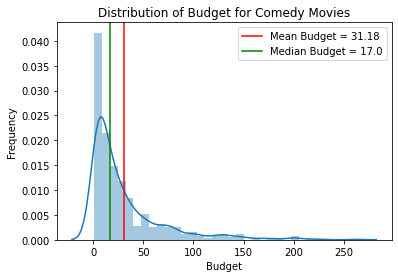

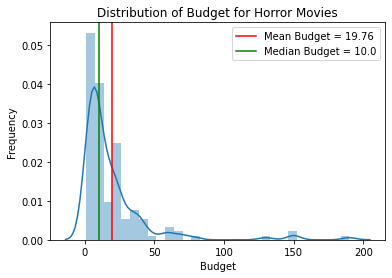

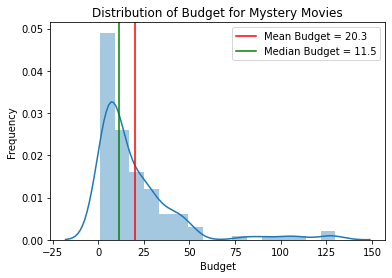

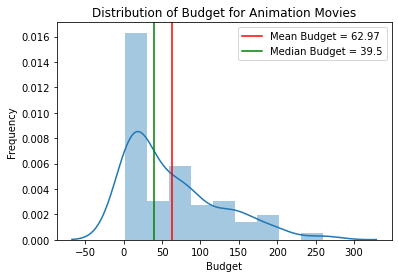

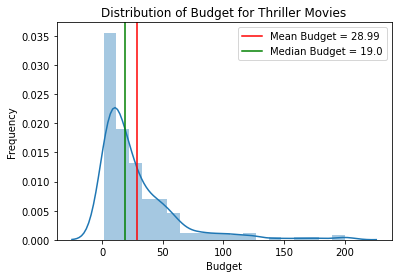

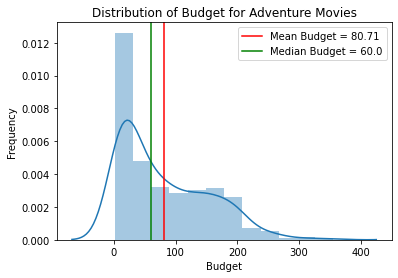

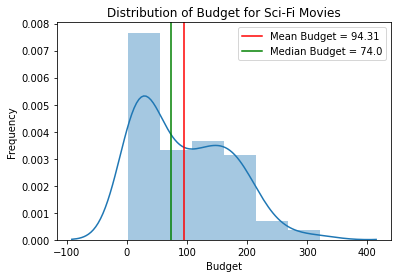

In [79]:
## plot histograms showing distribution of budgets for ea of the top genres
show_distplot(comedy_df, 'budget1mil', 'Comedy', 'Budget')
show_distplot(horror_df, 'budget1mil', 'Horror', 'Budget')
show_distplot(mystery_df, 'budget1mil', 'Mystery', 'Budget')
show_distplot(animation_df, 'budget1mil', 'Animation', 'Budget')
show_distplot(thriller_df, 'budget1mil', 'Thriller', 'Budget')
show_distplot(adventure_df, 'budget1mil', 'Adventure', 'Budget')
show_distplot(scifi_df, 'budget1mil', 'Sci-Fi', 'Budget')

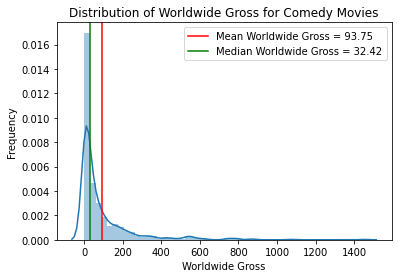

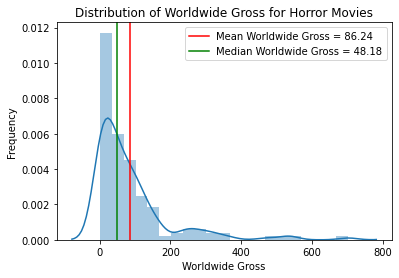

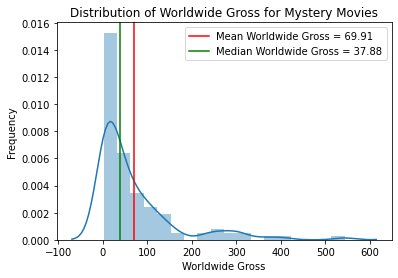

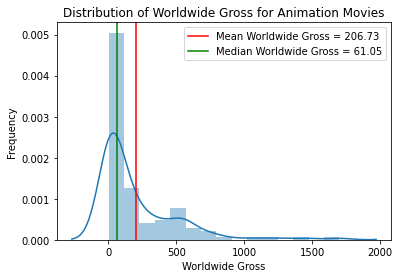

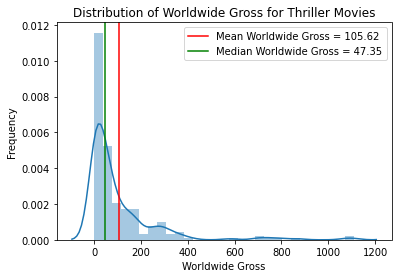

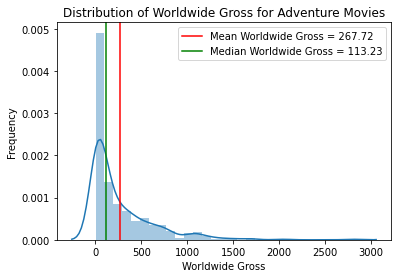

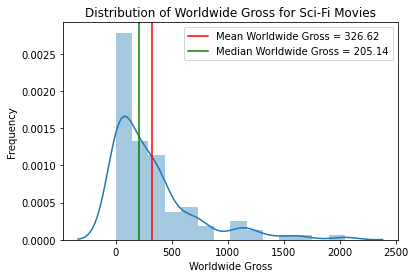

In [80]:
## plot histograms showing distribution of ww gross earnings for ea of the top genres
show_distplot(comedy_df, 'ww_gross1mil', 'Comedy', 'Worldwide Gross')
show_distplot(horror_df, 'ww_gross1mil', 'Horror', 'Worldwide Gross')
show_distplot(mystery_df, 'ww_gross1mil', 'Mystery', 'Worldwide Gross')
show_distplot(animation_df, 'ww_gross1mil', 'Animation', 'Worldwide Gross')
show_distplot(thriller_df, 'ww_gross1mil', 'Thriller', 'Worldwide Gross')
show_distplot(adventure_df, 'ww_gross1mil', 'Adventure', 'Worldwide Gross')
show_distplot(scifi_df, 'ww_gross1mil', 'Sci-Fi', 'Worldwide Gross')

/Users/maxsteele/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator


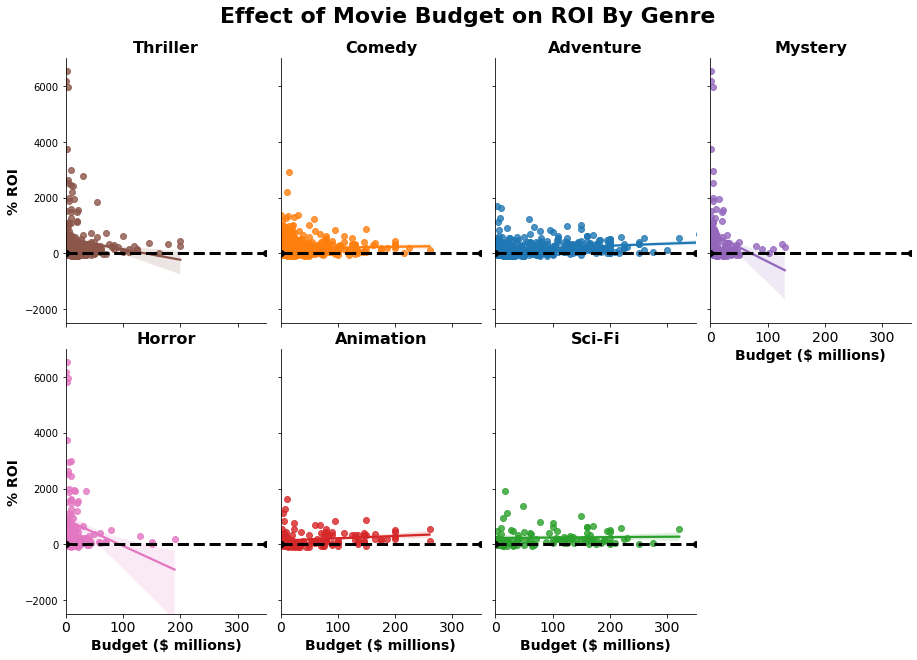

In [81]:
## plot a regression line plot for each top genre that shows the relationship
 ## between budget and ROI
g = sns.lmplot(x="budget1mil", y="ROI", col="top_genre_list", hue="top_genre_list", 
               data=explode_top_genres, col_wrap=4, height=4.5, aspect=.7,
               truncate=True, col_order=top_genre_list)
g.set(xlim=(0, 350), ylim=(-2500, 7000))

## plot a horizontal line at ROI = 0 to emphasize negative ROIs
g.map(plt.axhline, y=0, ls='--', c='k', linewidth=3)

## collapse the array of axes into 1 dimension so it's easy to iterate through
axes = g.axes.flatten()

## iterate through each genre in the list used to order the plots
 ## and assign that genre's name as the title of the subplot with the same index
for i, genre in enumerate(top_genre_list):
    axes[i].set_title(genre, fontsize=16, weight='bold')

axes[0].set_ylabel('% ROI', fontsize='14', weight='bold')
axes[4].set_ylabel('% ROI', fontsize='14', weight='bold')

for ax in axes[3:]:
    ax.set_xlabel('Budget ($ millions)', fontsize='14', weight='bold')
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)

g.fig.suptitle("Effect of Movie Budget on ROI By Genre", size=22, weight='bold')
g.fig.subplots_adjust(top=.9)

/Users/maxsteele/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator


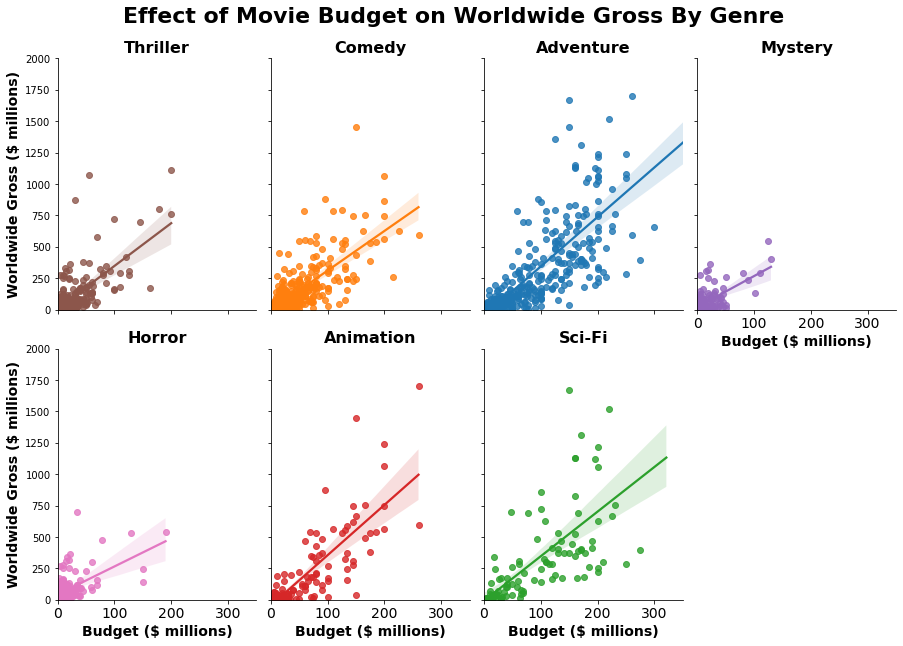

In [82]:
## plot a regression line plot for each top genre that shows the relationship
 ## between budget and ROI
g = sns.lmplot(x="budget1mil", y="ww_gross1mil", col="top_genre_list", hue="top_genre_list", 
               data=explode_top_genres, col_wrap=4, height=4.5, aspect=.7,
               truncate=True, col_order=top_genre_list)
g.set(xlim=(0, 350), ylim=(0, 2000))

## collapse the array of axes into 1 dimension so it's easy to iterate through
axes = g.axes.flatten()

## iterate through each genre in the list used to order the plots
 ## and assign that genre's name as the title of the subplot with the same index
for i, genre in enumerate(top_genre_list):
    axes[i].set_title(genre, fontsize=16, weight='bold')

axes[0].set_ylabel('Worldwide Gross ($ millions)', fontsize='14', weight='bold')
axes[4].set_ylabel('Worldwide Gross ($ millions)', fontsize='14', weight='bold')

for ax in axes[3:]:
    ax.set_xlabel('Budget ($ millions)', fontsize='14', weight='bold')
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)

g.fig.suptitle("Effect of Movie Budget on Worldwide Gross By Genre", size=22, weight='bold')
g.fig.subplots_adjust(top=.9)

For most of the top movie genres, a movie's budget does not appear to have a substantial effect on return on investment. Horror, Mystery, and Thriller movies stand out once again in this analysis. These movies have the potential to offer very high returns compared to relatively low investments. However, these genres appear to have a higher risk of negative returns on investment.

All top genres show a similar trend of increasing worldwide gross earnings with increasing movie budgets. The rate of increase (slope of the line) in gross earnings based on increasing movie budgets appears steepest for Adventure, Animation, and Sci-Fi movies. Based on the findings of the previous section, I recommended that the studio focus primarily on Adventure movies. These movies are among some of the most expensive to produce, but they offer consistently high returns and gross earnings compared to the other genres. 

Based on the analysis in this section, I recommend that the budget for Adventure movies be kept between the median for top grossing Adventure movies, \\$60 million, and a maximum of $150 million. Many of the top grossing Adventure movies fall within this range, and ROI does not appear to increase with movie budget beyond \\$150 million. If the studio chooses to focus secondarily on Comedy movies as previously suggested, budgets for those movies can be substantially lower. Budgets between the industry median for top grossing Comedies, \\$17 million and approximately \\$75 million appear to maximize ROI. In the previous section I found that Sci-Fi and Animation movies are generally more risky investments, but they have been performing better over the past few years. If Microsoft chooses to produce Sci-Fi or Animation movies, I recommend the budget for these movies not exceed \\$150 million each as ROI does not appear to increase beyond this level of investment.

# Q3: How does genre influence average movie rating?

/Users/maxsteele/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  import sys


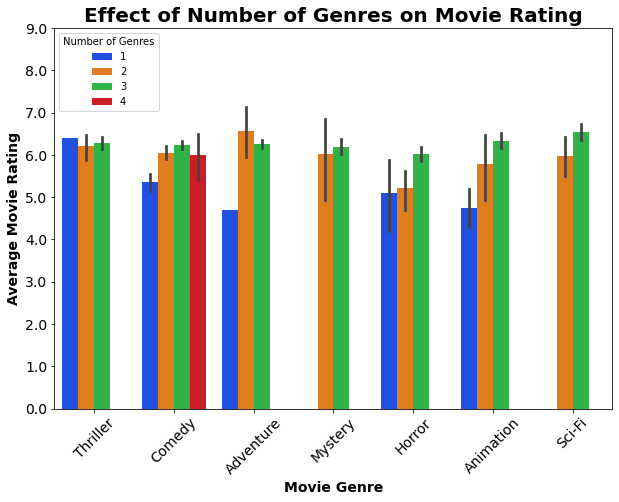

In [83]:
## plot a barplot that shows average movie rating by genre
 ## with multiple bars for each genre representing how many total genres the movie spans
ax = sns.barplot(x='top_genre_list', y='averageRating', hue='genre_count', palette='bright',
                 data=explode_top_genres, order=top_genre_list)
ax.set(ylim=(0, 9))
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=14)
ax.set_yticklabels(ax.get_yticks(), fontsize=14)
ax.set_xlabel('Movie Genre', fontsize=14, weight='bold')
ax.set_ylabel('Average Movie Rating', fontsize=14, weight='bold')
ax.set_title('Effect of Number of Genres on Movie Rating', fontsize=20, weight='bold')
ax.legend(title='Number of Genres')
ax.get_figure().set_size_inches((10,7))

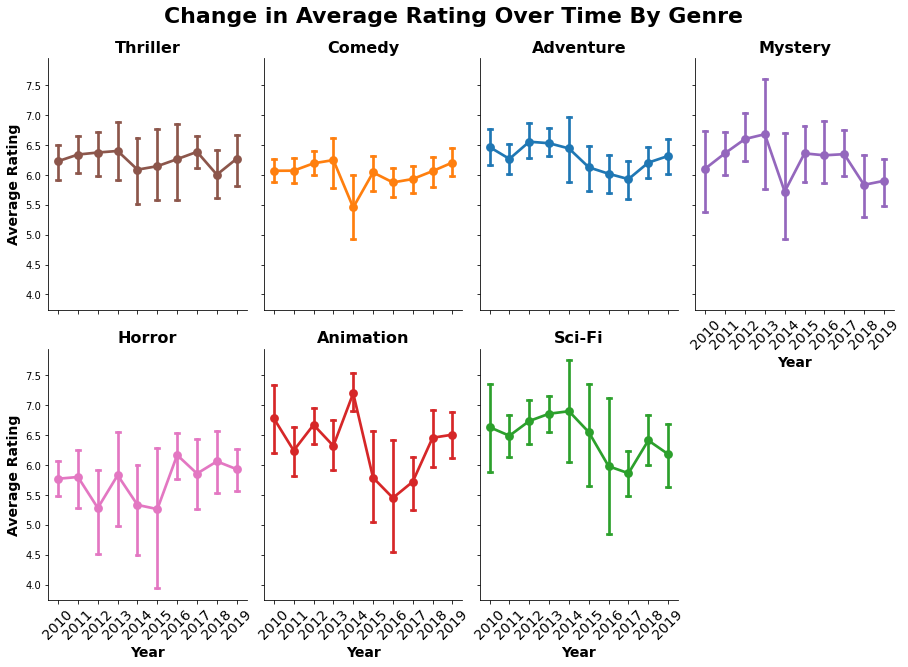

In [84]:
## make a point plot for each top genre showing how movie rating has changed over time    
g = sns.catplot(x="startYear", y="averageRating", col="top_genre_list", col_wrap=4,
                capsize=.2, height=4.5, aspect=.7, col_order=top_genre_list, hue="top_genre_list", 
                kind="point", data=explode_top_genres)

## collapse the array of axes into 1 dimension so it's easy to iterate through
axes = g.axes.flatten()

## iterate through each genre in the list used to order the plots
 ## and assign that genre's name as the title of the subplot with the same index
for i, genre in enumerate(top_genre_list):
    axes[i].set_title(genre, fontsize=16, weight='bold')

axes[0].set_ylabel('Average Rating', fontsize='14', weight='bold')
axes[4].set_ylabel('Average Rating', fontsize='14', weight='bold')

for ax in axes[3:]:
    ax.set_xlabel('Year', fontsize='14', weight='bold')

g.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=14)

g.fig.suptitle("Change in Average Rating Over Time By Genre", size=22, weight='bold')
g.fig.subplots_adjust(top=.9)

To make the new movie studio sustainable, not only do we need to make a profit off the movies produced, we also need to continue to attract top talent to work within our studio. Writers, producers, and actors may not want to become associated artistically with a studio that regularly produces poorly rated movies, even if they are still able to make a significant amount of money working for the studio. Without enlisting good writers, producers, and actors, the movie studio may struggle to find footing and remain viable over time. 

The results of the analyses in this section lend further support to my recommendation that the studio focus primarily on Adventure and Comedy movies. These movies are less risky financially, and have consistently been rated relatively highly since 2010 (except for Comedy movies in 2014). I have also recommended that the studio consider producing a few Animation and/or Sci-Fi movies to diversify its productions. Both categories are less consistent in terms of ratings when compared to Adventure and Comedy movies. Animation and Sci-Fi movies appear to have greater potential to be rated much higher, but also much lower than Adventure and Comedy movies.

The bulk of my analysis has focused on movie genres individually. This approach has been helpful in narrowing down our focus to a handful of movie types that are currently profitable and popular. However, movies typically fall into more than just one genre. I found that, among movies that fall into at least one top genre category, movies tend to achieve higher ratings when they span 2 to 3 genres, as opposed to only 1 genre. The studio should produce Adventure movies that also span a second genre. Comedy movies should span a total of 2 to 3 genres. Any Animation and Sci-Fi movies produced should span a total of 3 genres. Future work will seek to answer which specific genre combinations are likely to be the most well-received and profitable when focusing primarily on Adventure, Comedy, Animation, and Sci-Fi movies. 

# Conclusion and Recommendations

Because the movie industry is so diverse and many profitable movie studios are already well-established, a new movie studio should not try to compete on all fronts. Rather, Microsoft's new studio should limit its focus to producing quality movies that represent a subset of the total diversity. It also makes sense to focus on types of movies that have been profitable and well received in recent years.

I found that among the top movie genres, Adventure and Comedy movies are the most consistent in achieving high worldwide gross earnings, return on investment, and average movie ratings. I recommend that these types of movies be the studio's primary focus. I also identified Animation and Sci-Fi movies as riskier investments that are still worthy of consideration to diversify the studio's portfolio. The worldwide gross earnings and return on investment of both genres have increased in recent years. Ratings for Animation movies have also been on the rise. My specific recommendations for producing movies within each of these four genres are as follows:

- **Adventure**: This genre should be the primary focus for investment because it most consistently achieves high worldwide gross earnings and average ratings. It also presents lower risk of a negative return on investment, despite typically being made with higher budgets. The budget for each Adventure movie should be kept between the median budget for top grossing Adventure movies of \\$60 million and a maximum of \\$150 million. Adventure movies should also span 2 genres (Adventure and one other) for the best chance of attaining higher ratings.


* **Comedy**: This genre should be the secondary focus for investment because it also consistently achieves relatively high worldwide gross earnings and average ratings. It also presents a low risk of a negative return on investment and can be produced with lower investments than Adventure movies. The budget for each Comedy movie should be kept between the median budget for top grossing Comedy movies of \\$17 million and a maximum of \\$75 million to maximize return on investment. Comedy movies should span 2 to 3 genres (Comedy plus 1 or 2 others) for the best chance of attaining higher ratings.


* **Animation and/or Sci-Fi**: These genres should not be the a main focus for investment because they are associated with more risk. These types of movies can be expensive to make, but the budget for each Animation or Sci-Fi movie should be kept below \\$150 million to minimize risk. These movies should span 3 genres for the best chance of attaining higher ratings.

In [86]:
# folder = %pwd
# data_filepath = folder+'/data_files/'

# # save final DataFrames
# med_financial_df.to_csv(data_filepath+'full_final_imdb_data.csv')
# financial_explode_genre.to_csv(data_filepath+'full_genre_explode_data.csv')
# explode_top_genres.to_csv(data_filepath+'top_genre_explode_data.csv')